In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
import spacy
import string
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
pd.set_option('display.max_colwidth', 400)

df = pd.read_csv('mbti_1.csv')
df

type  \
0     INFJ   
1     ENTP   
2     INTP   
3     INTJ   
4     ENTJ   
...    ...   
8670  ISFP   
8671  ENFP   
8672  INTP   
8673  INFP   
8674  INFP   

                                                                                                                                                                                                                                                                                                                                                                                                                posts  
0     'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/...  
1     'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I ...  
2     'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (an...  
3     'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub,   Long time no see.  Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences...  
4     'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to.   Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. J...  
...                                                                                                                                                                                                                                                                                                                                                                                                               ...  
8670  'https://www.youtube.com/watch?v=t8edHB_h908|||IxFP just because I always think of cats as Fi doms for some reason.   https://www.youtube.com/watch?v=ib28iGc9go4|||Especially on websites that have become a haven for neo nazis, such as PerC.|||I'm such a nerd. I've been learning Dutch on Duolingo and I'm having so much fun :)|||Duolingo is the shit!  Oh my god I love this XD|||Right wingers do ...  
8671  'So...if this thread already exists someplace else (which it does:  http://personalitycafe.com/enfp-forum-inspirers/116902-movies-loved-enfp.html#post2952851), how the heck to I delete this one here???|||Ooops...I guess I didn't look too hard because I just started a Movies every ENFP should watch thread...|||So, this came up in the You Know You're An ENFP When... thread.  (@Pucca :  here we g...  
8672  'So many questions when i do these things.  I would take the purple pill. Pick winning lottery numbers. Do whatever I want.|||I worked in a brewery for a coupl

In [4]:
MBTI_TYPES = df['type'].unique().tolist()

In [5]:
MBTI_TYPES

['INFJ',
 'ENTP',
 'INTP',
 'INTJ',
 'ENTJ',
 'ENFJ',
 'INFP',
 'ENFP',
 'ISFP',
 'ISTP',
 'ISFJ',
 'ISTJ',
 'ESTP',
 'ESFP',
 'ESTJ',
 'ESFJ']

# EDA

## Target value

Let's at first explore target value and possible dependencies between different dichotomies.

In [6]:
df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

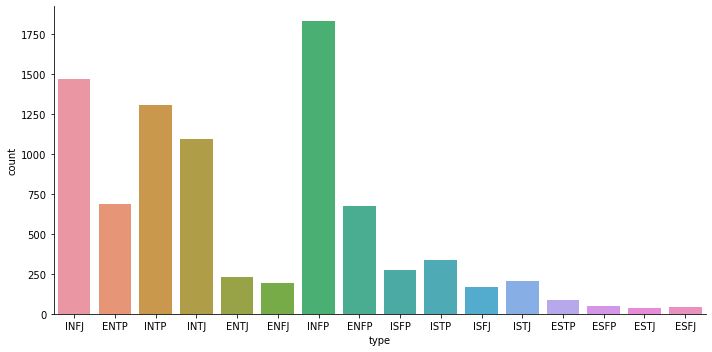

In [7]:
sns.catplot(x='type', kind='count', data=df, height=5, aspect=2)

We can see here that our dataset is very imbalanced. The top consists of types starting with *IN-* and contains majority of data. The most popular type *INFP* has 1832 instances, whereas the least popular *ESTJ* has only 39 instances. Such an imbalanced dataset may cause problems for accurate classification.

Let's look at number of each category in dichotomies.

In [8]:
from collections import defaultdict
categories = defaultdict(lambda: 0)

def increase(x):
    for i in range(len(x)):
        categories[x[i]]+=1

df['type'].apply(lambda x: increase(x))
categories = pd.DataFrame(categories.items(), columns=['category', 'num'])
categories = categories.sort_values(by=['num'], ascending=False)
categories

category   num
1        N  7478
0        I  6676
6        P  5241
2        F  4694
5        T  3981
3        J  3434
4        E  1999
7        S  1197

<AxesSubplot:xlabel='num', ylabel='category'>

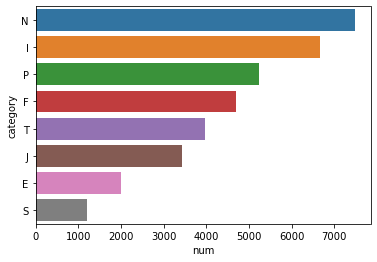

In [9]:
sns.barplot(x='num', y='category', data=categories)

## Dichotomies

<AxesSubplot:xlabel='category', ylabel='num'>

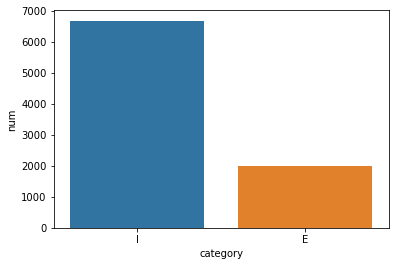

In [10]:
sns.barplot(x='category', y='num', data=categories.loc[categories['category'].isin(['I', 'E'])], orient='v')

<AxesSubplot:xlabel='category', ylabel='num'>

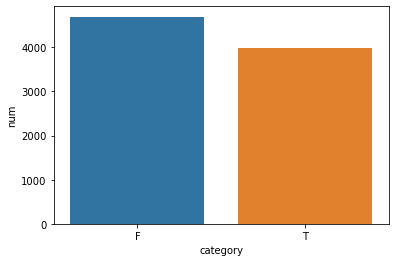

In [11]:
sns.barplot(x='category', y='num', data=categories.loc[categories['category'].isin(['T', 'F'])], orient='v')

<AxesSubplot:xlabel='category', ylabel='num'>

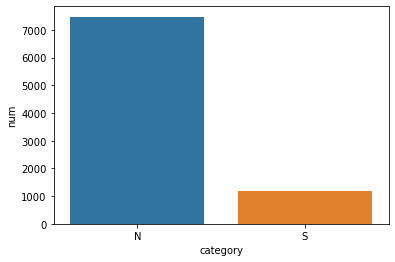

In [12]:
sns.barplot(x='category', y='num', data=categories.loc[categories['category'].isin(['S', 'N'])], orient='v')

<AxesSubplot:xlabel='category', ylabel='num'>

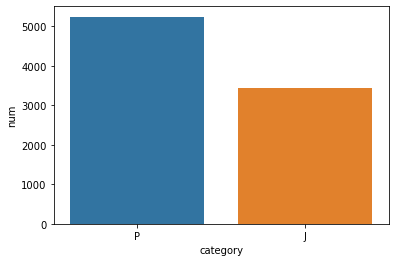

In [13]:
sns.barplot(x='category', y='num', data=categories.loc[categories['category'].isin(['J', 'P'])], orient='v')

We see that the only dichotomy that has almost uniformly distributed categories is `F/T`. For other dichotomies number of categories differ strongly. The biggest difference is in dichotomy `N/S`, where there is more than 7000 instances for category `N` and nearly 1000 instances for category `S`.

In [14]:
df['I/E'] = df['type'].apply(lambda x: x[0])
df['N/S'] = df['type'].apply(lambda x: x[1])
df['T/F'] = df['type'].apply(lambda x: x[2])
df['P/J'] = df['type'].apply(lambda x: x[3])

## Introverts/extraverts

In [15]:
df['I/E'] = df['type'].apply(lambda x: x[0])
df['N/S'] = df['type'].apply(lambda x: x[1])
df['T/F'] = df['type'].apply(lambda x: x[2])
df['P/J'] = df['type'].apply(lambda x: x[3])
def get_group(type):
    if type in ['INTJ', 'INTP', 'ENTJ', 'ENTP']:
        return 'analyst'
    if type in ['INFJ', 'INFP', 'ENFJ', 'ENFP']:
        return 'diplomat'
    if type in ['ISTJ', 'ISFJ', 'ESTJ', 'ESFJ']:
        return 'sentinel'
    return 'explorer'
    
df['group'] = df['type'].apply(lambda x: get_group(x))
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/...   
1  'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I ...   
2  'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (an...   
3  'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub,   Long time no see.  Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences...   
4  'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to.   Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. J...   

  I/E N/S T/F P/J     group  
0   I   N   F   J  diplomat  
1   E   N   T   P   analyst  
2   I   N   T   P   analyst  
3   I   N   T   J   analyst  
4   E   N   T   J   analyst

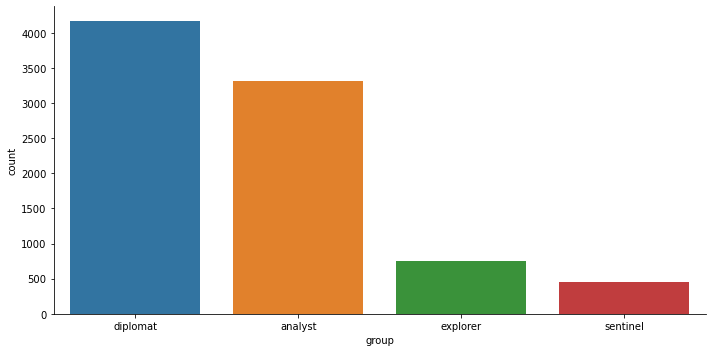

In [16]:
sns.catplot(x='group', kind='count', data=df, height=5, aspect=2)

Again, the dataset is highly imbalanced: diplomats should posess nearly 44% of the general population, analysts - 16.7%, explorers - 15%, and sentinels - 24%. Well, at least the diplomats are the most popular in the dataset!

Let's now look at how other dichotomies depend on whether person is an extravert or an introvert. We are going to use Chi-square test of independence of variables in a contingency table to determine whether values of other dichotomies are dependent on `I\E` dichotomy.

In [17]:
def get_independency_test(col1, col2, data):
    stat, p, dof, expected = chi2_contingency(pd.crosstab(data[col1], df[col2]))

    print(f'p-value={p}')
    if p < 0.5:
        print('p-value < alpha, so variables are dependent (reject H0)')
    else:
        print('p-value > alpha, so variables are independent (fail to reject H0)')

T/F         F         T
I/E                    
E    0.477739  0.522261
I    0.560066  0.439934

p-value=1.0864491564649589e-10
p-value < alpha, so variables are dependent (reject H0)


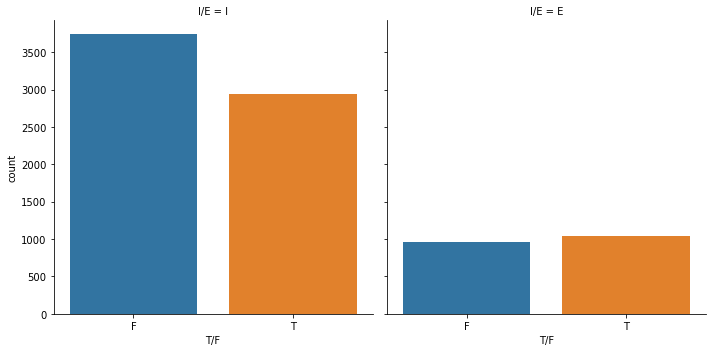

In [18]:
sns.catplot(x='T/F', kind='count', data=df, col='I/E')
display(pd.crosstab(df['I/E'], df['T/F'], normalize='index', colnames=['T/F'], rownames=['I/E']))
get_independency_test('I/E', 'T/F', df)

N/S         N         S
I/E                    
E    0.890945  0.109055
I    0.853355  0.146645

p-value=2.255058744694994e-05
p-value < alpha, so variables are dependent (reject H0)


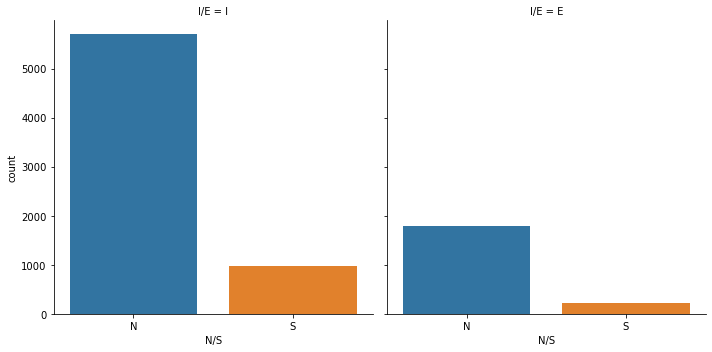

In [19]:
sns.catplot(x='N/S', kind='count', data=df, col='I/E')
display(pd.crosstab(df['I/E'], df['N/S'], normalize='index', colnames=['N/S'], rownames=['I/E']))
get_independency_test('I/E', 'N/S', df)

P/J         J         P
I/E                    
E    0.251126  0.748874
I    0.439185  0.560815

p-value=3.109134151777505e-51
p-value < alpha, so variables are dependent (reject H0)


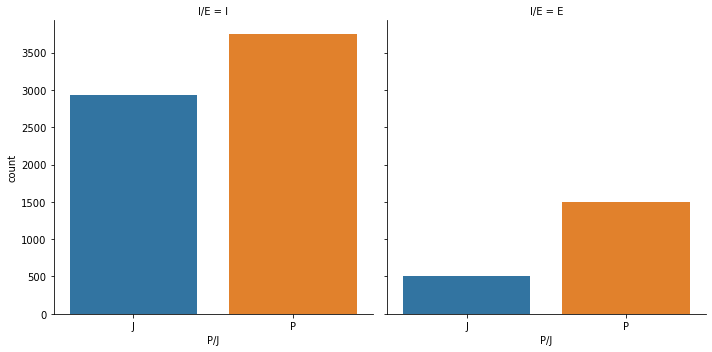

In [20]:
sns.catplot(x='P/J', kind='count', data=df, col='I/E')
display(pd.crosstab(df['I/E'], df['P/J'], normalize='index', colnames=['P/J'], rownames=['I/E']))
get_independency_test('I/E', 'P/J', df)

So, from test's results and barplots we can see that other dichotomies correlate with `I\E` dichotomy. Especially in case of `P/J` dichotomy, as there is almost the same percentage of `P` and `J` types for introverts, whereas 25% percents of extraverts have type `J` and other 75% have type `P`.

# Text preprocessing

Now let's start posts' preprocessing.

## Links

First of all, we need to remove all the links, encoding replacement characters and references to subreddits or reddit users.

In [21]:
df.loc[df['posts'].str.contains('https?:\/\/\S+\b|www\.(\w+\.)+\S*')]

type  \
0     INFJ   
1     ENTP   
2     INTP   
3     INTJ   
4     ENTJ   
...    ...   
8667  ENTP   
8669  INFJ   
8670  ISFP   
8672  INTP   
8674  INFP   

                                                                                                                                                                                                                                                                                                                                                                                                                posts  \
0     'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/...   
1     'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I ...   
2     'Good one  _____   https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (an...   
3     'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub,   Long time no see.  Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences...   
4     'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to.   Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. J...   
...                                                                                                                                                                                                                                                                                                                                                                                                               ...   
8667  'I think generally people experience post trauma in a very similar way, which is to seek security and try to rebuild themselves. That being said, I know of a couple who were mega extroverted, friendly...|||Like many other people on this thread, I find it absolutely astonishing that you couldn't find a job with that kind of qualification in a medical field. I would have to agree with @Mzansi th...   
8669  'I'm not sure about a method for picking out INFJ musical artists, but I have another name to throw into the cauldron: Jon Crosby, singer songwriter for VAST.  Additionally, he strikes me as 4w5 on...|||ThatOneWeirdGuy  Are you refering to the OP, the video I posted, or both?  You didn't specify.|||Dario Nardi's EEG tests continuing to bear fruit:   http://www.youtube.com/watch?v=YH9Zn7Glf3E&f...   
8670  'https://www.youtube.com/watch?v=t8edHB_h908|||IxFP just because I always think of cats as Fi doms for some reason.   https://www.youtube.com/watch?v=

In [22]:
df['posts'] = df['posts'].str.replace(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*','') #remove links
df['posts'] = df['posts'].str.replace(r'<U.....>|�','')                       #remove encoding replacement characters
df['posts'] = df['posts'].str.replace(r'/?\br/\w+','')                         #remove reference to subreddit
df['posts'] = df['posts'].str.replace(r'/?\bu/\w+','')                         #remove reference to reddit user

Delete all empty posts or posts containing only numbers

In [23]:
def delete_posts_without_letters(all_posts):
    for p in all_posts:
        if p.isspace() or not bool(re.search('[a-zA-Z]', p)):
            all_posts.remove(p)
    return all_posts

In [24]:
df['posts'] = df['posts'].apply(lambda x: x.split('|||'))

In [25]:
df['posts'] = df['posts'].apply(delete_posts_without_letters)

In [26]:
df['posts'] = df['posts'].apply(lambda x: '|||'.join(x))

In [27]:
df

type  \
0     INFJ   
1     ENTP   
2     INTP   
3     INTJ   
4     ENTJ   
...    ...   
8670  ISFP   
8671  ENFP   
8672  INTP   
8673  INFP   
8674  INFP   

                                                                                                                                                                                                                                                                                                                                                                                                                posts  \
0     ' and intj moments    sportscenter not top ten plays    pranks|||What has been the most life-changing experience in your life?|||     On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~    ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to no...   
1     'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I ...   
2     'Good one  _____    course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) ...   
3     'Dear INTP,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub,   Long time no see.  Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences...   
4     'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to.   Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. J...   
...                                                                                                                                                                                                                                                                                                                                                                                                               ...   
8670  ' just because I always think of cats as Fi doms for some reason.    on websites that have become a haven for neo nazis, such as PerC.|||I'm such a nerd. I've been learning Dutch on Duolingo and I'm having so much fun :)|||Duolingo is the shit!  Oh my god I love this XD|||Right wingers do this because they lack political consciousness.|||I doubt it, but if they are real then I hope to hell tha...   
8671  'So...if this thread already exists someplace else (which it does:  ), how the heck to I delete this one here???|||Ooops...I guess I didn't look too hard because I just started a Movies every ENFP should watch thread...|||So, this came up in the You Know You're An ENFP When... thread.  (@Pucca :  here we go!  IT IS DONE :D) This isn't a list of films with ENFPs IN them, but rather ones that yo...   
8672  'So many questions when i do these things.  I would take the purple pill. Pick winning lottery numbers. Do whatever I want.|||I worked in a brewery fo

### Deleting mbti types

Now, let's delete any mentions of mbti types in the posts. In [one of the papers we studied](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8234987/) author suggested such an approach, so that data leakage could be avoided.

In [28]:
def delete_mbti_type():
    for cur_type in MBTI_TYPES:
        df['posts'] = df['posts'].apply(lambda post: post.replace(cur_type, "").replace(cur_type.lower(), ""))


In [29]:
delete_mbti_type()

## Text stats

Let's now try to extract useful statistic from the posts.

In [30]:
df['posts'] = df['posts'].apply(lambda x: x.split('|||'))

### Length

In [31]:
df['avg_length'] = df['posts'].apply(lambda lst: np.mean([len(post) for post in lst]))

In [32]:
df_features = pd.concat([df['type'], df['group'], df['I/E'], df['N/S'], df['T/F'], df['P/J'], df['avg_length']], axis=1)
df_features.head()

type     group I/E N/S T/F P/J  avg_length
0  INFJ  diplomat   I   N   F   J   99.562500
1  ENTP   analyst   E   N   T   P  138.400000
2  INTP   analyst   I   N   T   P  124.282051
3  INTJ   analyst   I   N   T   J  124.708333
4  ENTJ   analyst   E   N   T   J  123.377778

In [33]:
df_features.groupby(['type']).mean()

avg_length
type            
ENFJ  150.348354
ENFP  148.107154
ENTJ  145.524004
ENTP  141.740469
ESFJ  149.260177
ESFP  128.377690
ESTJ  142.409772
ESTP  135.658110
INFJ  151.785349
INFP  148.333199
INTJ  146.246501
INTP  146.264224
ISFJ  146.722162
ISFP  140.274686
ISTJ  147.169201
ISTP  139.757139

In [34]:
df_features.groupby(['group']).mean()

avg_length
group               
analyst   145.270839
diplomat  149.606287
explorer  138.722546
sentinel  146.788659

<AxesSubplot:xlabel='type', ylabel='avg_length'>

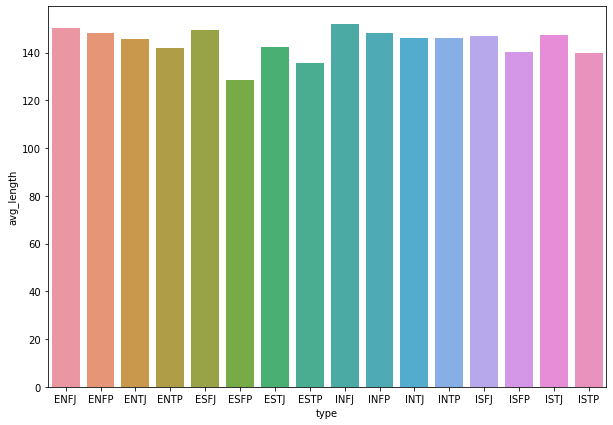

In [35]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).mean().index, y='avg_length', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='group', ylabel='avg_length'>

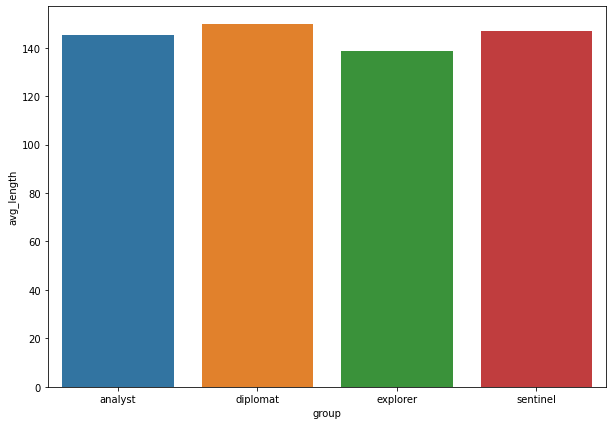

In [36]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).mean().index, y='avg_length', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='P/J', ylabel='avg_length'>

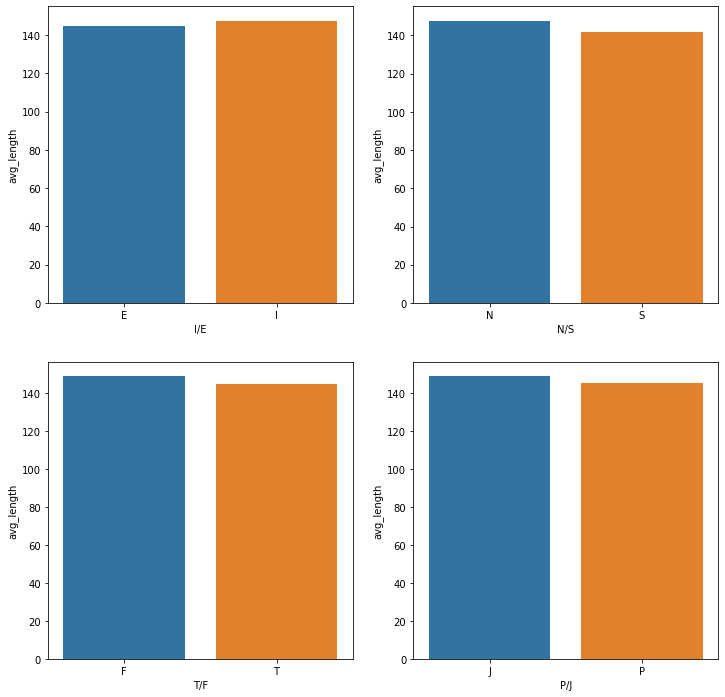

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).mean().index, y='avg_length', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).mean().index, y='avg_length', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).mean().index, y='avg_length', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).mean().index, y='avg_length', data=df_features.groupby(['P/J']).mean())

<AxesSubplot:xlabel='type', ylabel='avg_length'>

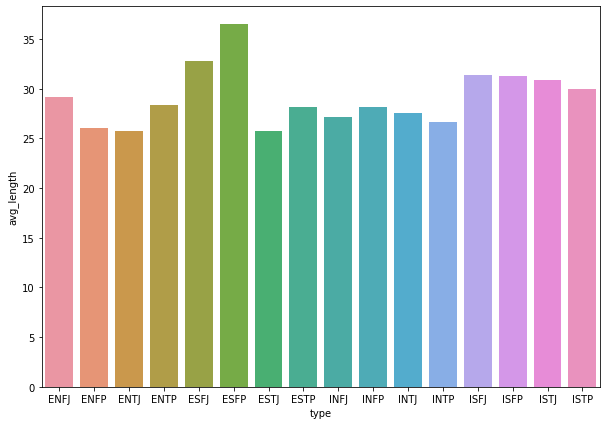

In [38]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).std().index, y='avg_length', data=df_features.groupby(['type']).std())

<AxesSubplot:xlabel='group', ylabel='avg_length'>

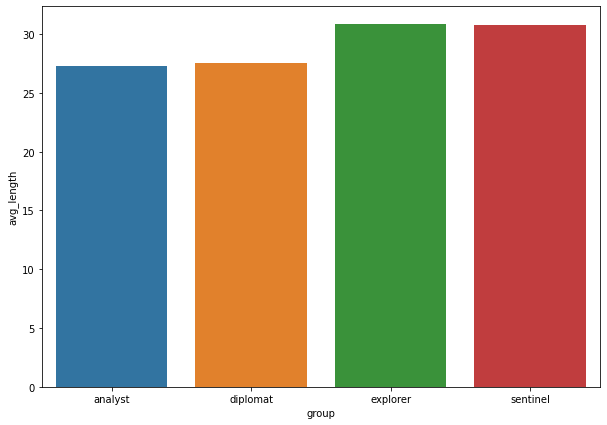

In [39]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).std().index, y='avg_length', data=df_features.groupby(['group']).std())

<AxesSubplot:xlabel='P/J', ylabel='avg_length'>

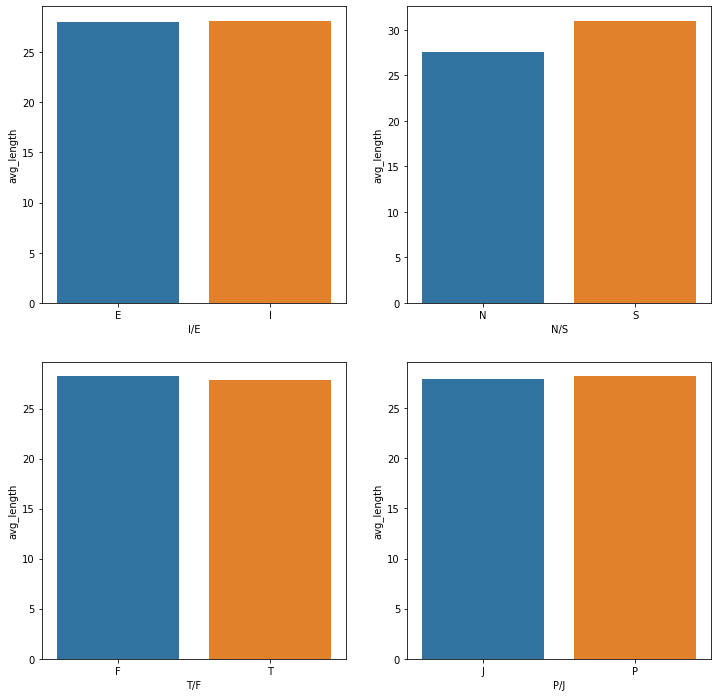

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).std().index, y='avg_length', data=df_features.groupby(['I/E']).std())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).std().index, y='avg_length', data=df_features.groupby(['N/S']).std())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).std().index, y='avg_length', data=df_features.groupby(['T/F']).std())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).std().index, y='avg_length', data=df_features.groupby(['P/J']).std())

We see that on average length(number of words) of all posts is almost the same for all types.

### Capital

In [41]:
df_features['num_capitals'] = df['posts'].apply(lambda lst: sum(1 for letter in ''.join(lst) if letter.isupper()))

In [42]:
df_features['ratio_capitals'] = df_features['num_capitals'] / df['posts'].apply(lambda lst: sum(1 for letter in ''.join(lst) if letter.isalpha()))

In [43]:
df_features = df_features.drop('num_capitals', 1)
df_features.head()

type     group I/E N/S T/F P/J  avg_length  ratio_capitals
0  INFJ  diplomat   I   N   F   J   99.562500        0.023096
1  ENTP   analyst   E   N   T   P  138.400000        0.050912
2  INTP   analyst   I   N   T   P  124.282051        0.037456
3  INTJ   analyst   I   N   T   J  124.708333        0.044050
4  ENTJ   analyst   E   N   T   J  123.377778        0.041830

<AxesSubplot:xlabel='type', ylabel='ratio_capitals'>

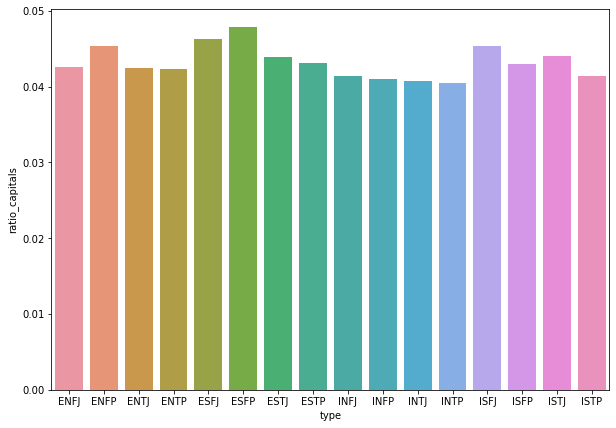

In [44]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).mean().index, y='ratio_capitals', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='group', ylabel='ratio_capitals'>

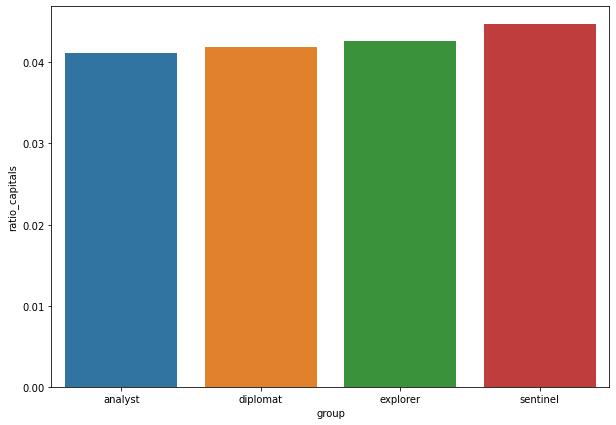

In [45]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).mean().index, y='ratio_capitals', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='P/J', ylabel='ratio_capitals'>

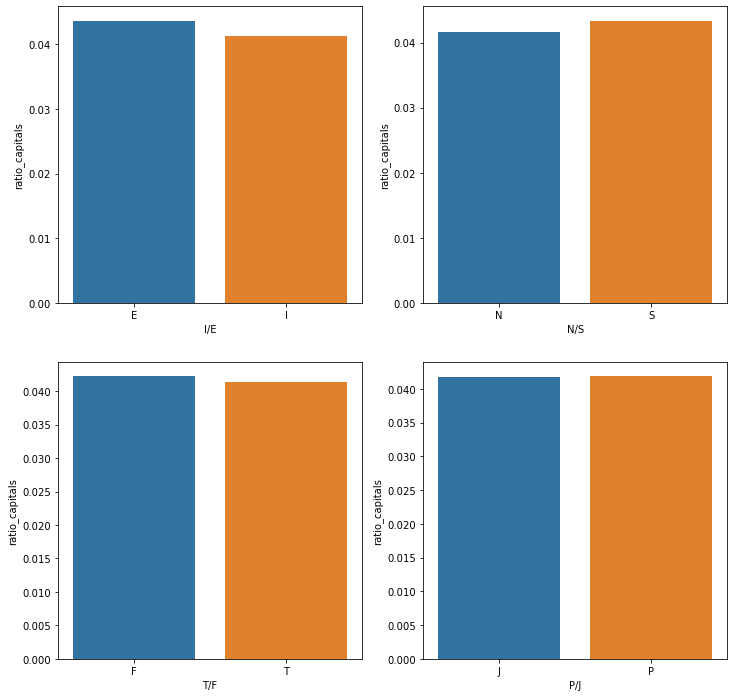

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).mean().index, y='ratio_capitals', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).mean().index, y='ratio_capitals', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).mean().index, y='ratio_capitals', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).mean().index, y='ratio_capitals', data=df_features.groupby(['P/J']).mean())

We see that ratio of capital letters to all letters is almost the same for all types.

### Punctuation

In [47]:
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  [' and  moments    sportscenter not top ten plays    pranks, What has been the most life-changing experience in your life?,      On repeat for most of today., May the PerC Experience immerse you., The last thing my  friend posted on his facebook before committing suicide the next day. Rest in peace~    7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection...   
1  ['I'm finding the lack of me in these posts very alarming., Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough..., Giving new meaning to 'Game' theory., Hello * Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknow...   
2  ['Good one  _____    course, to which I say I know; that's my blessing and my curse., Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at..., No, I didn't; thank you for a link!, So-called Ti-Si loop (and it can stem from any current topic/obsession) ca...   
3  ['Dear ,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created..., Dear  sub,   Long time no see.  Sincerely, Alpha, None of them. All other types hurt in deep existential ways that I want no part of., Probably a sliding scale that depends on individual preferences, like eve...   
4  ['You're fired., That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to.   Nobody wants to be approached with BS..., But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything., Never mind. Jus...   

  I/E N/S T/F P/J     group  avg_length  
0   I   N   F   J  diplomat   99.562500  
1   E   N   T   P   analyst  138.400000  
2   I   N   T   P   analyst  124.282051  
3   I   N   T   J   analyst  124.708333  
4   E   N   T   J   analyst  123.377778

In [48]:
def count_punctuation(posts):
    punc = 0
    for post in posts:
        for item in post:
            if item in string.punctuation:
                punc += 1
    return punc / sum([len(post) for post in posts])

def count_exclamation(posts):
    punc = 0
    for post in posts:
        for item in post:
            if item == '!':
                punc += 1
    return punc / sum([len(post) for post in posts])

In [49]:
df_features['punctuation'] = df['posts'].apply(count_punctuation)

In [50]:
df_features['exclamation_mark'] = df['posts'].apply(count_exclamation)

In [51]:
df_features.head()

type     group I/E N/S T/F P/J  avg_length  ratio_capitals  punctuation  \
0  INFJ  diplomat   I   N   F   J   99.562500        0.023096     0.043628   
1  ENTP   analyst   E   N   T   P  138.400000        0.050912     0.046403   
2  INTP   analyst   I   N   T   P  124.282051        0.037456     0.047039   
3  INTJ   analyst   I   N   T   J  124.708333        0.044050     0.049115   
4  ENTJ   analyst   E   N   T   J  123.377778        0.041830     0.041967   

   exclamation_mark  
0          0.000942  
1          0.000000  
2          0.000825  
3          0.000501  
4          0.000180

<AxesSubplot:xlabel='type', ylabel='punctuation'>

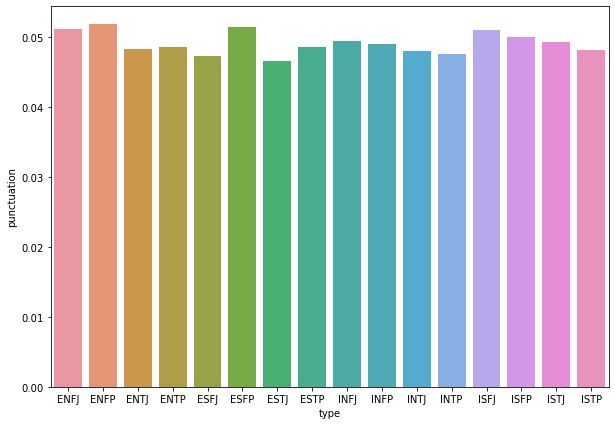

In [52]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).mean().index, y='punctuation', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='group', ylabel='punctuation'>

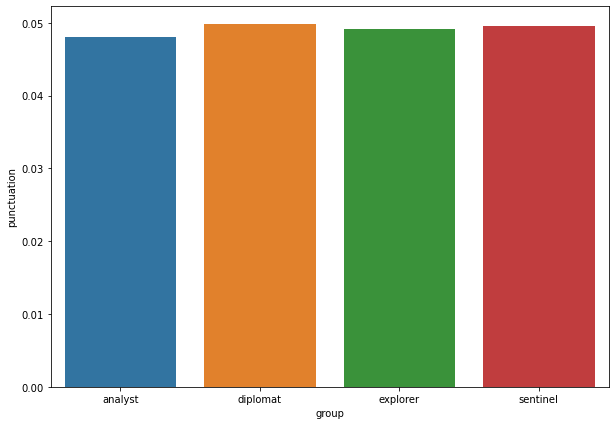

In [53]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).mean().index, y='punctuation', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='P/J', ylabel='punctuation'>

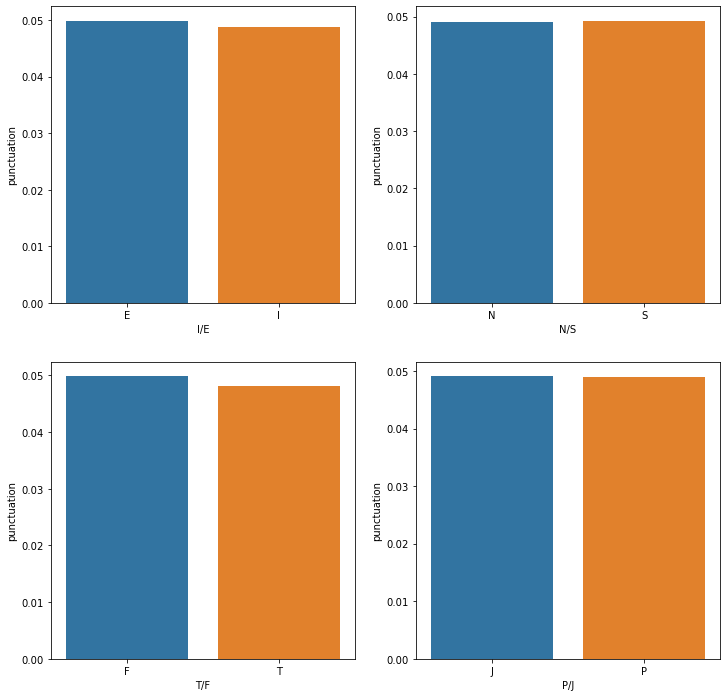

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).mean().index, y='punctuation', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).mean().index, y='punctuation', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).mean().index, y='punctuation', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).mean().index, y='punctuation', data=df_features.groupby(['P/J']).mean())

We see that average number of punctuation marks is almost the same for all types.

<AxesSubplot:xlabel='type', ylabel='exclamation_mark'>

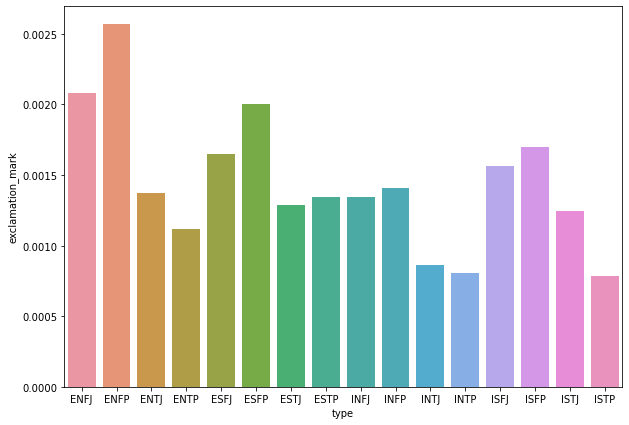

In [55]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).mean().index, y='exclamation_mark', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='group', ylabel='exclamation_mark'>

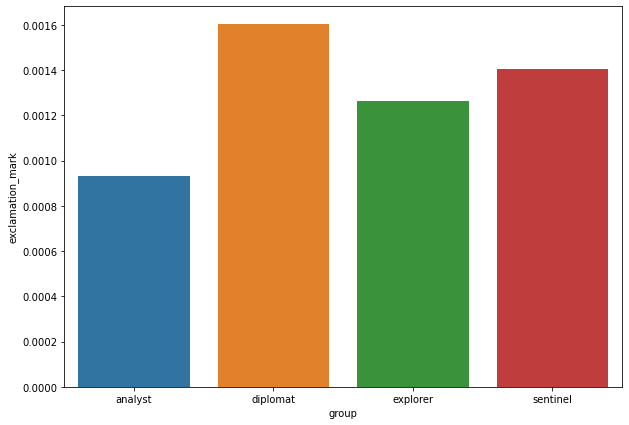

In [56]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).mean().index, y='exclamation_mark', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='P/J', ylabel='exclamation_mark'>

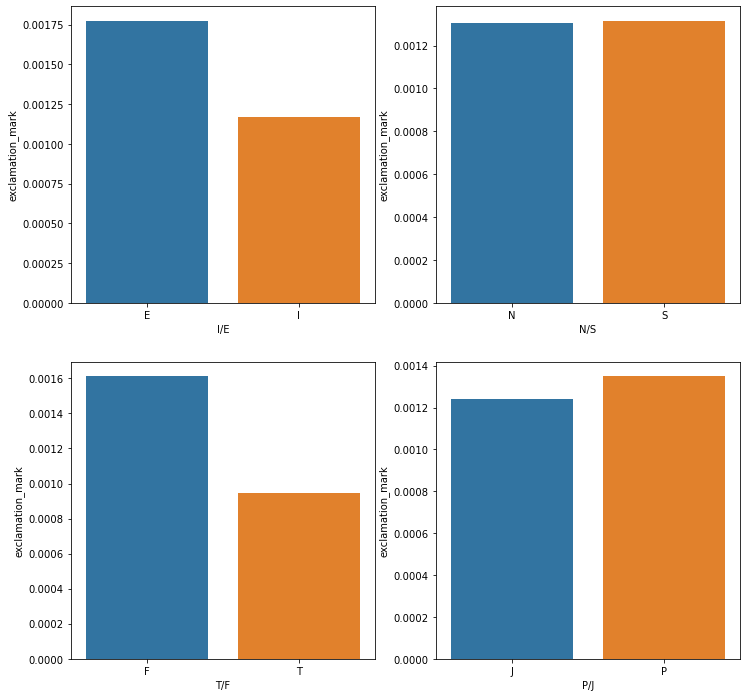

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).mean().index, y='exclamation_mark', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).mean().index, y='exclamation_mark', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).mean().index, y='exclamation_mark', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).mean().index, y='exclamation_mark', data=df_features.groupby(['P/J']).mean())

We see that average number of exclamation marks differ for different types. The biggest values are for *ENFJ* and *ENFP* types and lowest are for *INTJ* and *INTP*. Thefore, the number of exclamation mark can be a useful feature later.

### Sentiment

In [58]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [59]:
sia = SentimentIntensityAnalyzer()
def get_sentiment(posts):
    all_posts = ' '.join(posts)
    sent = sia.polarity_scores(all_posts)
    str_res = [str(val) for val in list(sent.values())]
    str_res = ' '.join(str_res)
    return str_res

In [60]:
df_features['polarity_scores'] = df['posts'].apply(get_sentiment)

In [61]:
df_features.head()

type     group I/E N/S T/F P/J  avg_length  ratio_capitals  punctuation  \
0  INFJ  diplomat   I   N   F   J   99.562500        0.023096     0.043628   
1  ENTP   analyst   E   N   T   P  138.400000        0.050912     0.046403   
2  INTP   analyst   I   N   T   P  124.282051        0.037456     0.047039   
3  INTJ   analyst   I   N   T   J  124.708333        0.044050     0.049115   
4  ENTJ   analyst   E   N   T   J  123.377778        0.041830     0.041967   

   exclamation_mark           polarity_scores  
0          0.000942  0.075 0.788 0.138 0.9869  
1          0.000000  0.087 0.716 0.197 0.9993  
2          0.000825  0.079 0.714 0.207 0.9991  
3          0.000501  0.053 0.812 0.135 0.9984  
4          0.000180   0.147 0.691 0.161 0.928

In [62]:
def get_neg(string):
    return float(string.split()[0])

def get_neu(string):
    return float(string.split()[1])

def get_pos(string):
    return float(string.split()[2])

df_features['neg'] = df_features['polarity_scores'].apply(get_neg)
df_features['neu'] = df_features['polarity_scores'].apply(get_neu)
df_features['pos'] = df_features['polarity_scores'].apply(get_pos)

df_features = df_features.drop('polarity_scores', 1)


In [63]:
df_features.head()

type     group I/E N/S T/F P/J  avg_length  ratio_capitals  punctuation  \
0  INFJ  diplomat   I   N   F   J   99.562500        0.023096     0.043628   
1  ENTP   analyst   E   N   T   P  138.400000        0.050912     0.046403   
2  INTP   analyst   I   N   T   P  124.282051        0.037456     0.047039   
3  INTJ   analyst   I   N   T   J  124.708333        0.044050     0.049115   
4  ENTJ   analyst   E   N   T   J  123.377778        0.041830     0.041967   

   exclamation_mark    neg    neu    pos  
0          0.000942  0.075  0.788  0.138  
1          0.000000  0.087  0.716  0.197  
2          0.000825  0.079  0.714  0.207  
3          0.000501  0.053  0.812  0.135  
4          0.000180  0.147  0.691  0.161

<AxesSubplot:xlabel='type', ylabel='pos'>

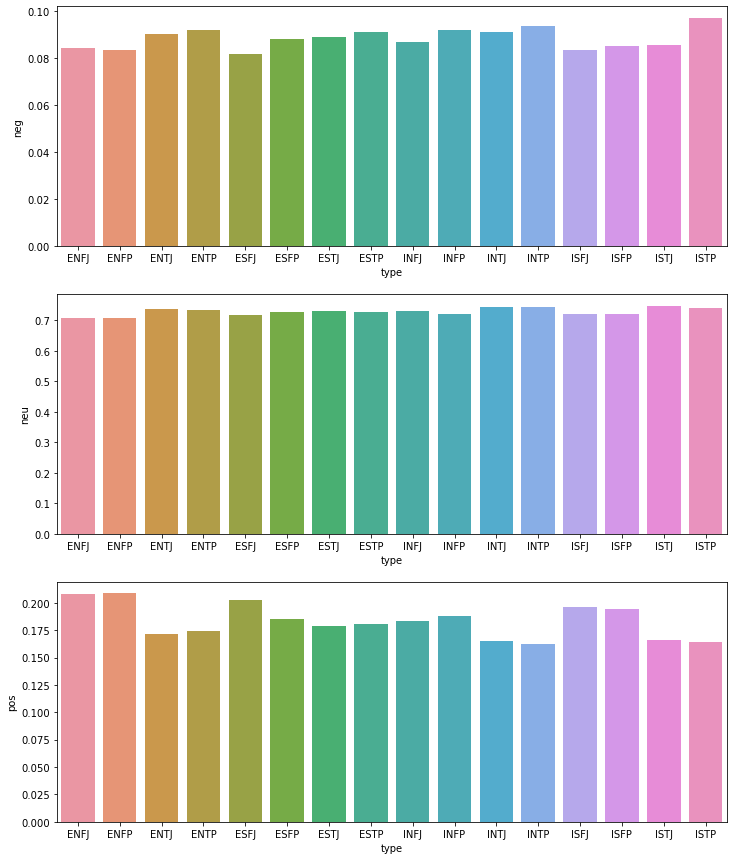

In [64]:
fig, ax = plt.subplots(3, 1, figsize=(12, 15))
sns.barplot(ax=ax[0], x=df_features.groupby(['type']).mean().index, y='neg', data=df_features.groupby(['type']).mean())
sns.barplot(ax=ax[1], x=df_features.groupby(['type']).mean().index, y='neu', data=df_features.groupby(['type']).mean())
sns.barplot(ax=ax[2], x=df_features.groupby(['type']).mean().index, y='pos', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='group', ylabel='pos'>

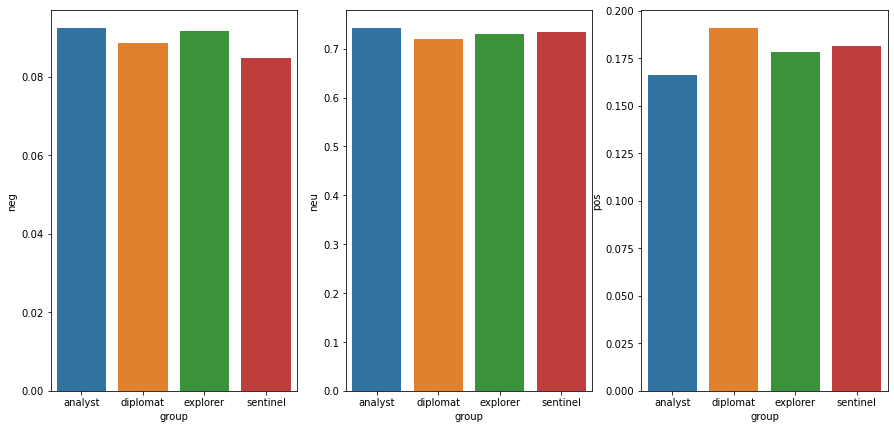

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
sns.barplot(ax=ax[0], x=df_features.groupby(['group']).mean().index, y='neg', data=df_features.groupby(['group']).mean())
sns.barplot(ax=ax[1], x=df_features.groupby(['group']).mean().index, y='neu', data=df_features.groupby(['group']).mean())
sns.barplot(ax=ax[2], x=df_features.groupby(['group']).mean().index, y='pos', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='I/E', ylabel='pos'>

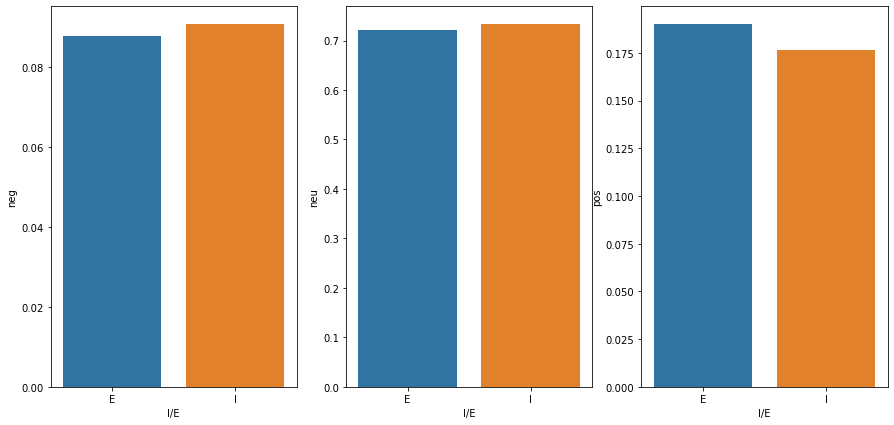

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
sns.barplot(ax=ax[0], x=df_features.groupby(['I/E']).mean().index, y='neg', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[1], x=df_features.groupby(['I/E']).mean().index, y='neu', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[2], x=df_features.groupby(['I/E']).mean().index, y='pos', data=df_features.groupby(['I/E']).mean())

<AxesSubplot:xlabel='N/S', ylabel='pos'>

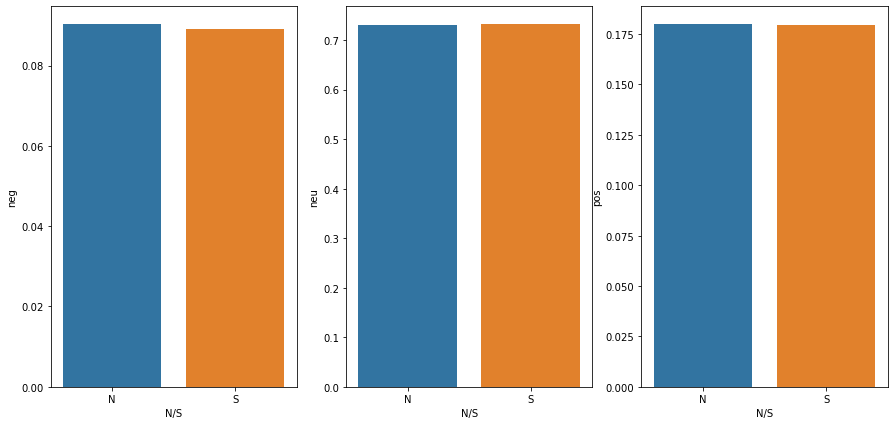

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
sns.barplot(ax=ax[0], x=df_features.groupby(['N/S']).mean().index, y='neg', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1], x=df_features.groupby(['N/S']).mean().index, y='neu', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[2], x=df_features.groupby(['N/S']).mean().index, y='pos', data=df_features.groupby(['N/S']).mean())

<AxesSubplot:xlabel='T/F', ylabel='pos'>

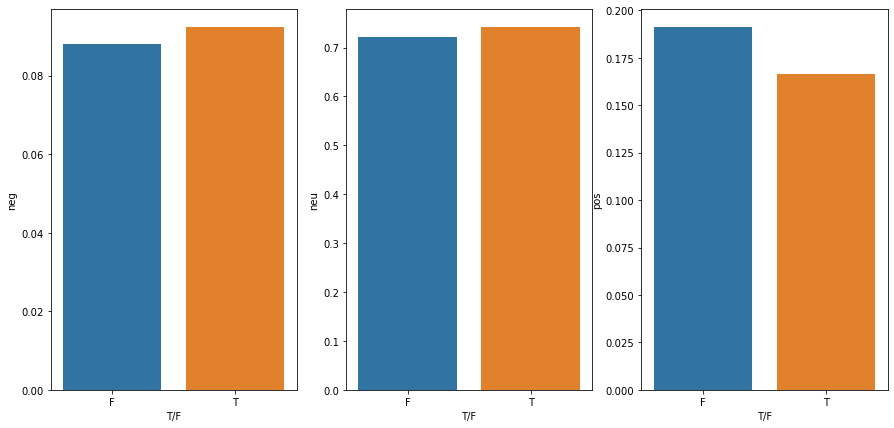

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
sns.barplot(ax=ax[0], x=df_features.groupby(['T/F']).mean().index, y='neg', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1], x=df_features.groupby(['T/F']).mean().index, y='neu', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[2], x=df_features.groupby(['T/F']).mean().index, y='pos', data=df_features.groupby(['T/F']).mean())

<AxesSubplot:xlabel='P/J', ylabel='pos'>

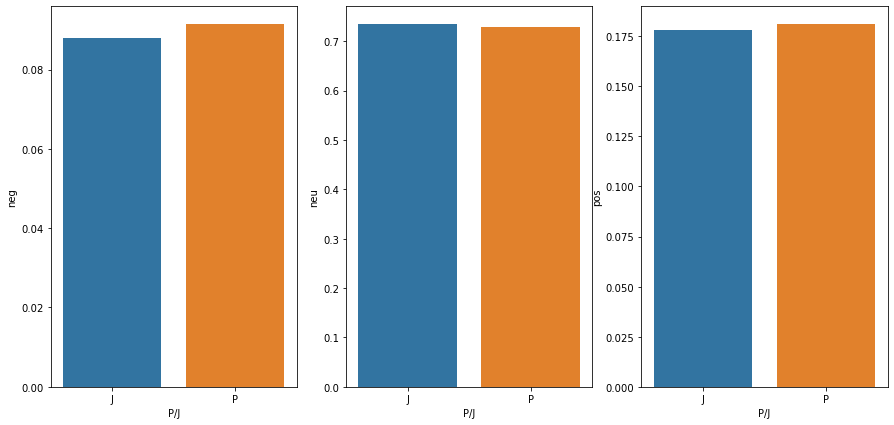

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
sns.barplot(ax=ax[0], x=df_features.groupby(['P/J']).mean().index, y='neg', data=df_features.groupby(['P/J']).mean())
sns.barplot(ax=ax[1], x=df_features.groupby(['P/J']).mean().index, y='neu', data=df_features.groupby(['P/J']).mean())
sns.barplot(ax=ax[2], x=df_features.groupby(['P/J']).mean().index, y='pos', data=df_features.groupby(['P/J']).mean())

We can see that sentiment is not that different for the types.

### Slang usage

In [70]:
df_slang = pd.read_csv('twitterSlang.csv', error_bad_lines=False, warn_bad_lines=False)

In [71]:
df_slang

slang      formal_translation
0        ab                   about
1       abt                   about
2       b/c                 because
3         b                      be
4        b4                  before
..      ...                     ...
99   afaik         as far as i know
100     dyk            did you know
101    fbf         flashback Friday
102      ff           follow Friday
103   tgif   thank god it is friday

[104 rows x 2 columns]

In [72]:
slang_list = set(df_slang['slang'].to_numpy())

def count_slang(posts):
    res = 0
    for post in posts:
        post = post.lower()
        words = post.split()
        res += len([word for word in words if word in slang_list])
    return res / sum([len(post.split()) for post in posts])

In [73]:
df_features['slang'] = df['posts'].apply(count_slang)

<AxesSubplot:xlabel='type', ylabel='slang'>

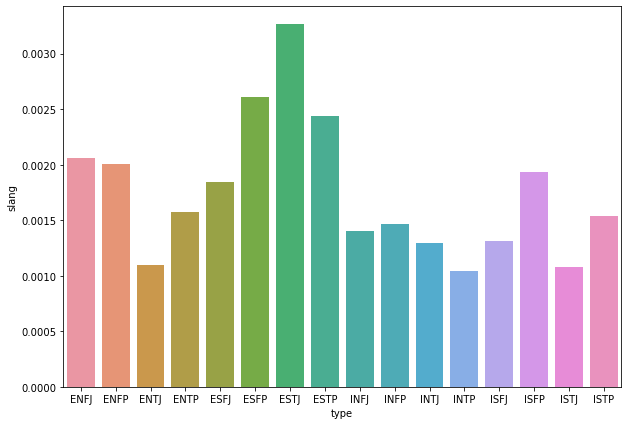

In [74]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).mean().index, y='slang', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='group', ylabel='slang'>

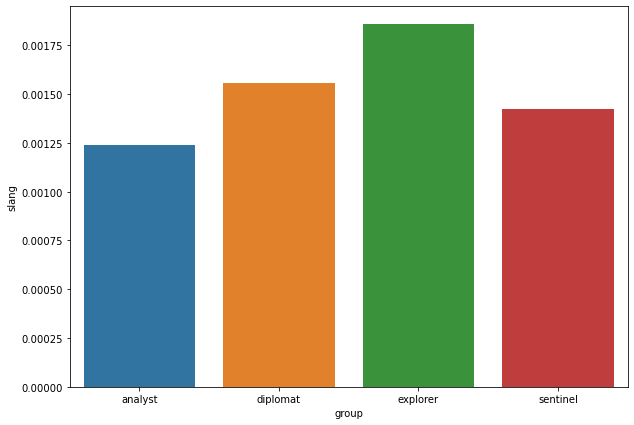

In [75]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).mean().index, y='slang', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='P/J', ylabel='slang'>

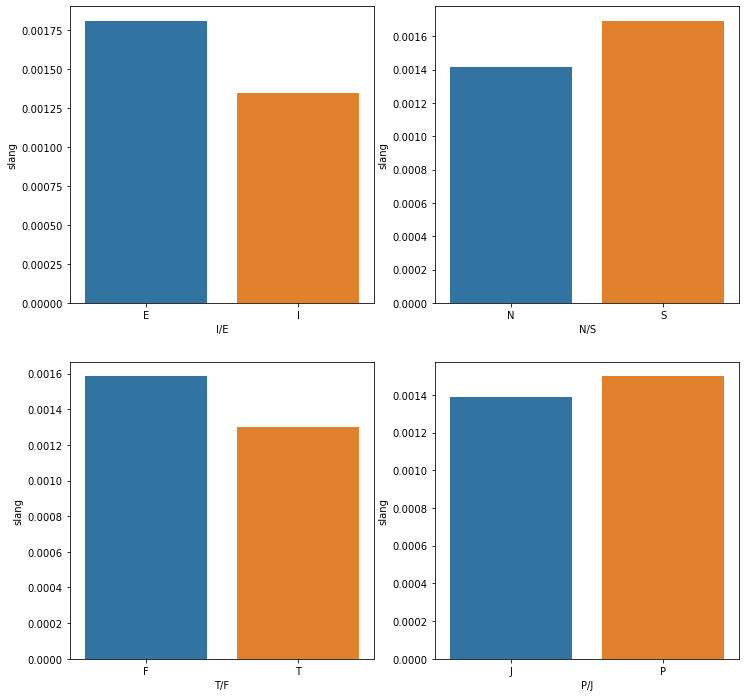

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).mean().index, y='slang', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).mean().index, y='slang', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).mean().index, y='slang', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).mean().index, y='slang', data=df_features.groupby(['P/J']).mean())

Slang can be a useful feature: it differs from type to type, from group to group and from dichotomy to dichotomy.

## Emoticons

In [77]:
df['posts'] = df['posts'].apply(lambda x: ' '.join(x))

In [78]:
# Emoticon conversion
eyes = r"[8:=;]"
nose = r"['`\-]?"
df['posts'] = df['posts'].str.replace(r"\b{}{}[)pD]+\b|\b[(d]+{}{}\b".format(eyes, nose, nose, eyes), " SMILEFACE ")
df['posts'] = df['posts'].str.replace(r"\b{}{}\(+\b|\b\)+{}{}\b".format(eyes, nose, nose, eyes), " SADFACE ")

In [79]:
df_features['smile'] = df['posts'].str.count('SMILEFACE')
df_features['sad'] = df['posts'].str.count('SADFACE')

<AxesSubplot:xlabel='type', ylabel='smile'>

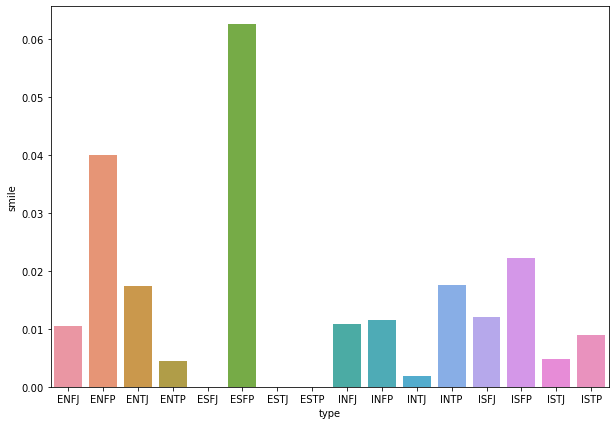

In [80]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).mean().index, y='smile', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='type', ylabel='sad'>

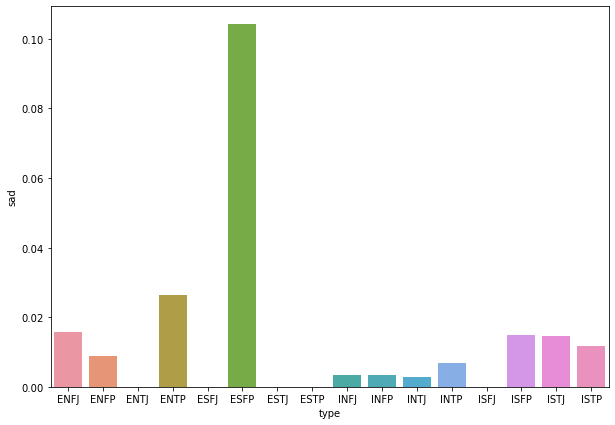

In [81]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['type']).mean().index, y='sad', data=df_features.groupby(['type']).mean())

<AxesSubplot:xlabel='group', ylabel='smile'>

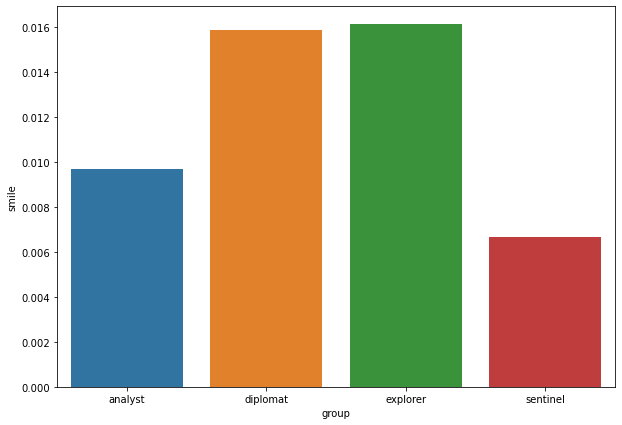

In [82]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).mean().index, y='smile', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='group', ylabel='sad'>

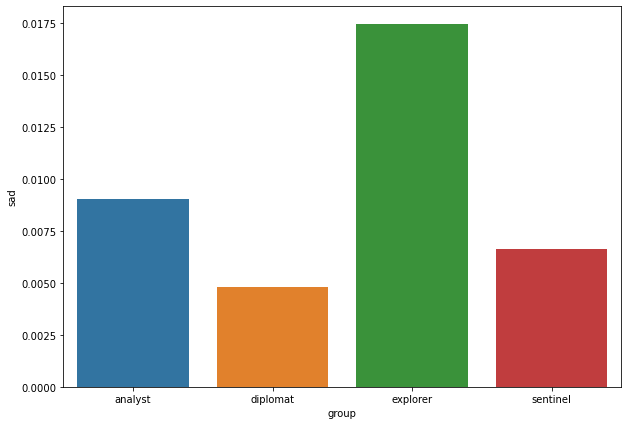

In [83]:
plt.subplots(figsize=(10,7))
sns.barplot(x=df_features.groupby(['group']).mean().index, y='sad', data=df_features.groupby(['group']).mean())

<AxesSubplot:xlabel='P/J', ylabel='smile'>

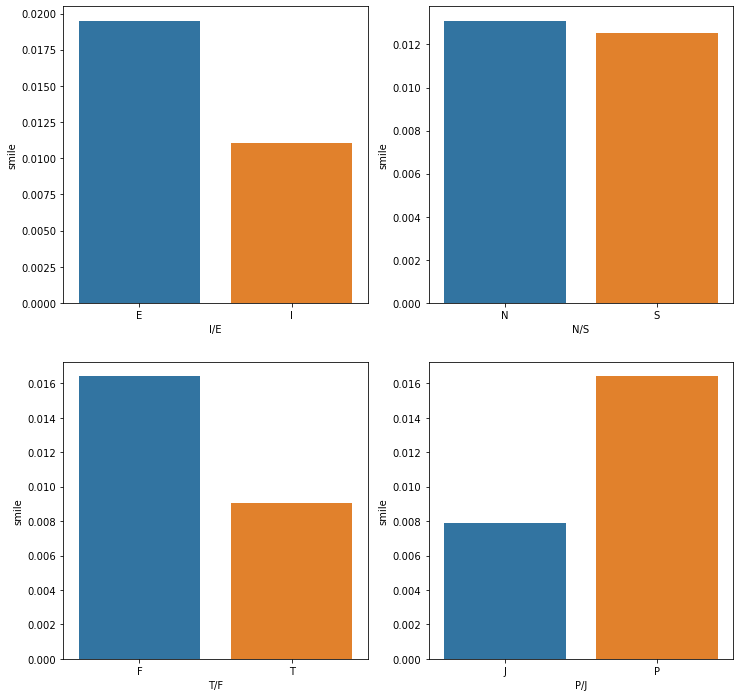

In [84]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).mean().index, y='smile', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).mean().index, y='smile', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).mean().index, y='smile', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).mean().index, y='smile', data=df_features.groupby(['P/J']).mean())

<AxesSubplot:xlabel='P/J', ylabel='sad'>

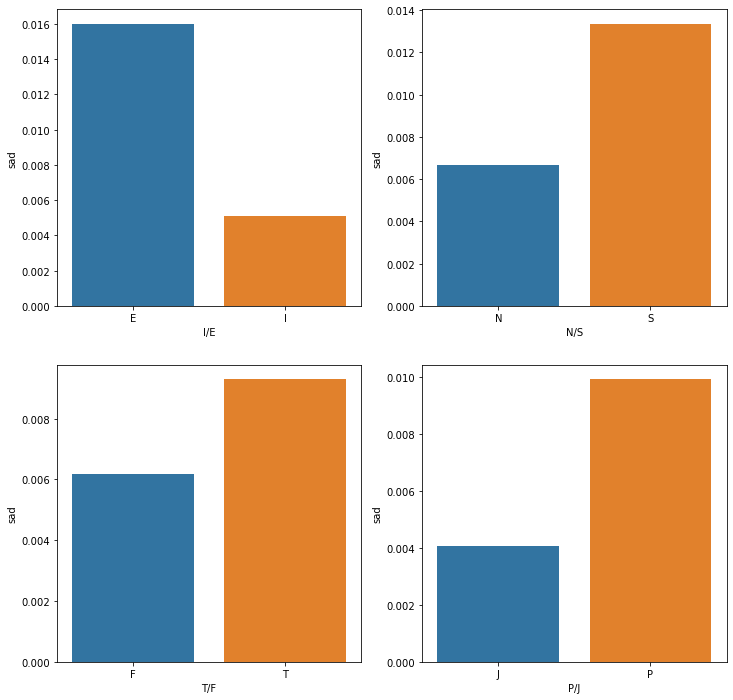

In [85]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
sns.barplot(ax=ax[0, 0], x=df_features.groupby(['I/E']).mean().index, y='sad', data=df_features.groupby(['I/E']).mean())
sns.barplot(ax=ax[0, 1], x=df_features.groupby(['N/S']).mean().index, y='sad', data=df_features.groupby(['N/S']).mean())
sns.barplot(ax=ax[1, 0], x=df_features.groupby(['T/F']).mean().index, y='sad', data=df_features.groupby(['T/F']).mean())
sns.barplot(ax=ax[1, 1], x=df_features.groupby(['P/J']).mean().index, y='sad', data=df_features.groupby(['P/J']).mean())

Even though emoticon usage differs for personality types, it probaby is not that useful, because there is not a lot of them. :(

## Cleaning

Let's clean the data from extra spaces and numbers and convert all words to lower case.

In [86]:
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  ' and  moments    sportscenter not top ten plays    pranks What has been the most life-changing experience in your life?      On repeat for most of today. May the PerC Experience immerse you. The last thing my  friend posted on his facebook before committing suicide the next day. Rest in peace~    7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all ...   
1  'I'm finding the lack of me in these posts very alarming. Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough... Giving new meaning to 'Game' theory. Hello * Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledg...   
2  'Good one  _____    course, to which I say I know; that's my blessing and my curse. Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes.   Or it's more I could be madly in love in case I reconciled my feelings (which at... No, I didn't; thank you for a link! So-called Ti-Si loop (and it can stem from any current topic/obsession) can be...   
3  'Dear ,   I enjoyed our conversation the other day.  Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created... Dear  sub,   Long time no see.  Sincerely, Alpha None of them. All other types hurt in deep existential ways that I want no part of. Probably a sliding scale that depends on individual preferences, like everyth...   
4  'You're fired. That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to.   Nobody wants to be approached with BS... But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything. Never mind. Just go...   

  I/E N/S T/F P/J     group  avg_length  
0   I   N   F   J  diplomat   99.562500  
1   E   N   T   P   analyst  138.400000  
2   I   N   T   P   analyst  124.282051  
3   I   N   T   J   analyst  124.708333  
4   E   N   T   J   analyst  123.377778

In [88]:
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

In [89]:
df['posts'] = df['posts'].apply(remove_numbers)

In [90]:
def remove_whitespaces(text):
    result = re.sub(' +', ' ', text.strip())
    return result

In [91]:
df['posts'] = df['posts'].apply(remove_whitespaces)

In [92]:
df['posts'] = df['posts'].str.lower()

In [93]:
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  ' and moments sportscenter not top ten plays pranks what has been the most life-changing experience in your life? on repeat for most of today. may the perc experience immerse you. the last thing my friend posted on his facebook before committing suicide the next day. rest in peace~ . sorry to hear of your distress. it's only natural for a relationship to not be perfection all the time in every...   
1  'i'm finding the lack of me in these posts very alarming. sex can be boring if it's in the same position often. for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. there isn't enough... giving new meaning to 'game' theory. hello * grin* that's all it takes. than we converse and they do most of the flirting while i acknowledge...   
2  'good one _____ course, to which i say i know; that's my blessing and my curse. does being absolutely positive that you and your best friend could be an amazing couple count? if so, than yes. or it's more i could be madly in love in case i reconciled my feelings (which at... no, i didn't; thank you for a link! so-called ti-si loop (and it can stem from any current topic/obsession) can be deadl...   
3  'dear , i enjoyed our conversation the other day. esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created... dear sub, long time no see. sincerely, alpha none of them. all other types hurt in deep existential ways that i want no part of. probably a sliding scale that depends on individual preferences, like everything in ...   
4  'you're fired. that's another silly misconception. that approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to. nobody wants to be approached with bs... but guys... he really wants to go on a super-duper-long-ass vacation. c'mon guys. his boss just doesn't listen or get it. he even approached him logically and everything. never mind. just go o...   

  I/E N/S T/F P/J     group  avg_length  
0   I   N   F   J  diplomat   99.562500  
1   E   N   T   P   analyst  138.400000  
2   I   N   T   P   analyst  124.282051  
3   I   N   T   J   analyst  124.708333  
4   E   N   T   J   analyst  123.377778

## Tokenization

In [94]:
df['posts'] = df['posts'].apply(lambda post: post.replace('-', ""))
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  ' and moments sportscenter not top ten plays pranks what has been the most lifechanging experience in your life? on repeat for most of today. may the perc experience immerse you. the last thing my friend posted on his facebook before committing suicide the next day. rest in peace~ . sorry to hear of your distress. it's only natural for a relationship to not be perfection all the time in every ...   
1  'i'm finding the lack of me in these posts very alarming. sex can be boring if it's in the same position often. for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. there isn't enough... giving new meaning to 'game' theory. hello * grin* that's all it takes. than we converse and they do most of the flirting while i acknowledge...   
2  'good one _____ course, to which i say i know; that's my blessing and my curse. does being absolutely positive that you and your best friend could be an amazing couple count? if so, than yes. or it's more i could be madly in love in case i reconciled my feelings (which at... no, i didn't; thank you for a link! socalled tisi loop (and it can stem from any current topic/obsession) can be deadly....   
3  'dear , i enjoyed our conversation the other day. esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created... dear sub, long time no see. sincerely, alpha none of them. all other types hurt in deep existential ways that i want no part of. probably a sliding scale that depends on individual preferences, like everything in ...   
4  'you're fired. that's another silly misconception. that approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to. nobody wants to be approached with bs... but guys... he really wants to go on a superduperlongass vacation. c'mon guys. his boss just doesn't listen or get it. he even approached him logically and everything. never mind. just go on p...   

  I/E N/S T/F P/J     group  avg_length  
0   I   N   F   J  diplomat   99.562500  
1   E   N   T   P   analyst  138.400000  
2   I   N   T   P   analyst  124.282051  
3   I   N   T   J   analyst  124.708333  
4   E   N   T   J   analyst  123.377778

### Saving mid-results to file

In [95]:
# df.to_csv(path_or_buf='before_stop_words_removal.csv',index=False)

In [96]:
# df = pd.read_csv('before_stop_words_removal.csv')
# df

In [97]:
from spacy.lang.en import English
nlp = English()

df['posts'] = df['posts'].apply(lambda post: [token.text for token in nlp(post)])

In [98]:
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  [', and, moments, sportscenter, not, top, ten, plays, pranks, what, has, been, the, most, lifechanging, experience, in, your, life, ?, on, repeat, for, most, of, today, ., may, the, perc, experience, immerse, you, ., the, last, thing, my, friend, posted, on, his, facebook, before, committing, suicide, the, next, day, ., rest, in, peace~, ., sorry, to, hear, of, your, distress, ., it, 's, only,...   
1  [', i, 'm, finding, the, lack, of, me, in, these, posts, very, alarming, ., sex, can, be, boring, if, it, 's, in, the, same, position, often, ., for, example, me, and, my, girlfriend, are, currently, in, an, environment, where, we, have, to, creatively, use, cowgirl, and, missionary, ., there, is, n't, enough, ..., giving, new, meaning, to, ', game, ', theory, ., hello, *, grin, *, that, 's, a...   
2  [', good, one, _, _, _, _, _, course, ,, to, which, i, say, i, know, ;, that, 's, my, blessing, and, my, curse, ., does, being, absolutely, positive, that, you, and, your, best, friend, could, be, an, amazing, couple, count, ?, if, so, ,, than, yes, ., or, it, 's, more, i, could, be, madly, in, love, in, case, i, reconciled, my, feelings, (, which, at, ..., no, ,, i, did, n't, ;, thank, you, f...   
3  [', dear, ,, i, enjoyed, our, conversation, the, other, day, ., esoteric, gabbing, about, the, nature, of, the, universe, and, the, idea, that, every, rule, and, social, code, being, arbitrary, constructs, created, ..., dear, sub, ,, long, time, no, see, ., sincerely, ,, alpha, none, of, them, ., all, other, types, hurt, in, deep, existential, ways, that, i, want, no, part, of, ., probably, a,...   
4  [', you, 're, fired, ., that, 's, another, silly, misconception, ., that, approaching, is, logically, is, going, to, be, the, key, to, unlocking, whatever, it, is, you, think, you, are, entitled, to, ., nobody, wants, to, be, approached, with, bs, ..., but, guys, ..., he, really, wants, to, go, on, a, superduperlongass, vacation, ., c'm, on, guys, ., his, boss, just, does, n't, listen, or, get...   

  I/E N/S T/F P/J     group  avg_length  
0   I   N   F   J  diplomat   99.562500  
1   E   N   T   P   analyst  138.400000  
2   I   N   T   P   analyst  124.282051  
3   I   N   T   J   analyst  124.708333  
4   E   N   T   J   analyst  123.377778

## Punctuation

Let's now remove punctuation.

In [99]:
def remove_punctuation(text):
    result = [el.strip(string.punctuation+string.whitespace) for el in text if \
            (el not in string.punctuation) and (el not in string.whitespace) and el is not None]
    return result

In [100]:
df['posts'] = df['posts'].apply(remove_punctuation)

In [101]:
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  [and, moments, sportscenter, not, top, ten, plays, pranks, what, has, been, the, most, lifechanging, experience, in, your, life, on, repeat, for, most, of, today, may, the, perc, experience, immerse, you, the, last, thing, my, friend, posted, on, his, facebook, before, committing, suicide, the, next, day, rest, in, peace, sorry, to, hear, of, your, distress, it, s, only, natural, for, a, relat...   
1  [i, m, finding, the, lack, of, me, in, these, posts, very, alarming, sex, can, be, boring, if, it, s, in, the, same, position, often, for, example, me, and, my, girlfriend, are, currently, in, an, environment, where, we, have, to, creatively, use, cowgirl, and, missionary, there, is, n't, enough, , giving, new, meaning, to, game, theory, hello, grin, that, s, all, it, takes, than, we, converse...   
2  [good, one, course, to, which, i, say, i, know, that, s, my, blessing, and, my, curse, does, being, absolutely, positive, that, you, and, your, best, friend, could, be, an, amazing, couple, count, if, so, than, yes, or, it, s, more, i, could, be, madly, in, love, in, case, i, reconciled, my, feelings, which, at, , no, i, did, n't, thank, you, for, a, link, socalled, tisi, loop, and, it, can, s...   
3  [dear, i, enjoyed, our, conversation, the, other, day, esoteric, gabbing, about, the, nature, of, the, universe, and, the, idea, that, every, rule, and, social, code, being, arbitrary, constructs, created, , dear, sub, long, time, no, see, sincerely, alpha, none, of, them, all, other, types, hurt, in, deep, existential, ways, that, i, want, no, part, of, probably, a, sliding, scale, that, depe...   
4  [you, re, fired, that, s, another, silly, misconception, that, approaching, is, logically, is, going, to, be, the, key, to, unlocking, whatever, it, is, you, think, you, are, entitled, to, nobody, wants, to, be, approached, with, bs, , but, guys, , he, really, wants, to, go, on, a, superduperlongass, vacation, c'm, on, guys, his, boss, just, does, n't, listen, or, get, it, he, even, approached...   

  I/E N/S T/F P/J     group  avg_length  
0   I   N   F   J  diplomat   99.562500  
1   E   N   T   P   analyst  138.400000  
2   I   N   T   P   analyst  124.282051  
3   I   N   T   J   analyst  124.708333  
4   E   N   T   J   analyst  123.377778

## Stop Words

In [102]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [103]:
all_stopwords = stopwords.words('english')
all_stopwords.append("'m")
all_stopwords.append("'s")
all_stopwords.append("n't")
all_stopwords.append("ve")
all_stopwords.append("'ve")
all_stopwords.append("re")
all_stopwords.append("'re")
all_stopwords.append("'ll")
all_stopwords.append("would")
all_stopwords.append("could")
all_stopwords.append("also")
all_stopwords.append("nt")
all_stopwords = set(all_stopwords)
all_stopwords

{"'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'could',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 "n't",
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'nt',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or

In [104]:
df['posts'] = df['posts'].apply(lambda lst: [el.replace("`", "'") for el in lst])

In [105]:
def remove_stop_words(post):
    return [word for word in post if not word in all_stopwords]

In [106]:
df['posts'] = df['posts'].apply(remove_stop_words)

In [107]:
df.head(10)

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   
5  INTJ   
6  INFJ   
7  INTJ   
8  INFJ   
9  INTP   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  [moments, sportscenter, top, ten, plays, pranks, lifechanging, experience, life, repeat, today, may, perc, experience, immerse, last, thing, friend, posted, facebook, committing, suicide, next, day, rest, peace, sorry, hear, distress, natural, relationship, perfection, time, every, moment, existence, try, figure, hard, times, times, growth, , welcome, stuff, game, set, match, prozac, wellbruti...   
1  [finding, lack, posts, alarming, sex, boring, position, often, example, girlfriend, currently, environment, creatively, use, cowgirl, missionary, enough, , giving, new, meaning, game, theory, hello, grin, takes, converse, flirting, acknowledge, presence, return, words, smooth, wordplay, cheeky, grins, lack, balance, hand, eye, coordination, real, iq, test, score, internet, iq, tests, funny, sc...   
2  [good, one, course, say, know, blessing, curse, absolutely, positive, best, friend, amazing, couple, count, yes, madly, love, case, reconciled, feelings, , thank, link, socalled, tisi, loop, stem, current, topic, obsession, deadly, like, stuck, thoughts, mind, wanders, circles, feels, truly, terrible, , noticed, peculiar, vegetation, look, grass, dozens, different, plant, species, imagine, hun...   
3  [dear, enjoyed, conversation, day, esoteric, gabbing, nature, universe, idea, every, rule, social, code, arbitrary, constructs, created, , dear, sub, long, time, see, sincerely, alpha, none, types, hurt, deep, existential, ways, want, part, probably, sliding, scale, depends, individual, preferences, like, everything, humanity, draco, malfoy, say, either, either, though, stacking, somewhat, arb...   
4  [fired, another, silly, misconception, approaching, logically, going, key, unlocking, whatever, think, entitled, nobody, wants, approached, bs, , guys, , really, wants, go, superduperlongass, vacation, c'm, guys, boss, listen, get, even, approached, logically, everything, never, mind, go, permanent, vacation, two, months, crazy, idea, really, best, employee, may, cooking, wants, reliable, asse...   
5  [science, perfect, scientist, claims, scientific, information, revised, discover, new, things, rational, thinking, useful, society, , edgar, allen, poe, siggy, people, see, obvious, fi, quick, put, agree, ne, see, compare, haku, definite, flat, naruto, , , lets, get, party, started, say, disproved, god, merely, said, found, methods, disturbing, although, bring, certain, questions, god, control...   
6  [ca, draw, nails, haha, done, professionals, nails, yes, gel, mean, posted, done, nails, awesome, probably, electronic, screen, syndrome, advent, technology, social, media, suffer, overstimulation, daily, basis, guilty, well, past, happy, , love, nail, arts, mine, first, time, hearing, menstruation, church, thanks, sharing, yeah, crazy, thought, taoists, belief, dear, bad, person, trying, get,...   
7  [tend, build, collection, things, desktop, use, frequently, move, folder, called, everything, get, sorted, type, sub, type, ike, collect, odd, objects, even, work, , lot, people, call, junk, like, collect, old, unused, software, ill, take, hands, , bunch, old, adobe, , think, quite, normal, tend, see, friends, real, life, every, couple, months, said, earlier, people, get, good, ones, , edit, m...   
8  [sure, good, question, distinction, two, dependant, perception, quote, robb, flynn, , hate, feel, nothing, love, feel, win, war, , good, question, tough, say, sure, loved, winona, ryder, lydia, beetlejuice, , lonely, much, t

### Saving mid-results to file

In [108]:
# df.to_csv(path_or_buf='after_stop_words_removal.csv',index=False)

In [109]:
# import ast
# df = pd.read_csv('after_stop_words_removal.csv')
# df['posts'] = df['posts'].apply(lambda x: ast.literal_eval(x))

## Lemmatization

Let's now perform lemmatization.

In [111]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [112]:
def perform_lemmatization(lst):
    return [lemmatizer.lemmatize(word) for word in lst]

In [113]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [114]:
df['posts'] = df['posts'].apply(perform_lemmatization)

In [115]:
df.head()

type  \
0  INFJ   
1  ENTP   
2  INTP   
3  INTJ   
4  ENTJ   

                                                                                                                                                                                                                                                                                                                                                                                                             posts  \
0  [moment, sportscenter, top, ten, play, prank, lifechanging, experience, life, repeat, today, may, perc, experience, immerse, last, thing, friend, posted, facebook, committing, suicide, next, day, rest, peace, sorry, hear, distress, natural, relationship, perfection, time, every, moment, existence, try, figure, hard, time, time, growth, , welcome, stuff, game, set, match, prozac, wellbrutin, le...   
1  [finding, lack, post, alarming, sex, boring, position, often, example, girlfriend, currently, environment, creatively, use, cowgirl, missionary, enough, , giving, new, meaning, game, theory, hello, grin, take, converse, flirting, acknowledge, presence, return, word, smooth, wordplay, cheeky, grin, lack, balance, hand, eye, coordination, real, iq, test, score, internet, iq, test, funny, score, ...   
2  [good, one, course, say, know, blessing, curse, absolutely, positive, best, friend, amazing, couple, count, yes, madly, love, case, reconciled, feeling, , thank, link, socalled, tisi, loop, stem, current, topic, obsession, deadly, like, stuck, thought, mind, wanders, circle, feel, truly, terrible, , noticed, peculiar, vegetation, look, grass, dozen, different, plant, specie, imagine, hundred, ...   
3  [dear, enjoyed, conversation, day, esoteric, gabbing, nature, universe, idea, every, rule, social, code, arbitrary, construct, created, , dear, sub, long, time, see, sincerely, alpha, none, type, hurt, deep, existential, way, want, part, probably, sliding, scale, depends, individual, preference, like, everything, humanity, draco, malfoy, say, either, either, though, stacking, somewhat, arbitra...   
4  [fired, another, silly, misconception, approaching, logically, going, key, unlocking, whatever, think, entitled, nobody, want, approached, b, , guy, , really, want, go, superduperlongass, vacation, c'm, guy, bos, listen, get, even, approached, logically, everything, never, mind, go, permanent, vacation, two, month, crazy, idea, really, best, employee, may, cooking, want, reliable, asset, gone,...   

  I/E N/S T/F P/J     group  avg_length  
0   I   N   F   J  diplomat   99.562500  
1   E   N   T   P   analyst  138.400000  
2   I   N   T   P   analyst  124.282051  
3   I   N   T   J   analyst  124.708333  
4   E   N   T   J   analyst  123.377778

# Most popular words

In [116]:
from wordcloud import WordCloud
def plot_wordcloud(data, mbti_type=None, dichotomy=None, dichotomy_type=None, num_words=30):

    if mbti_type:
        text = " ".join(post for post in data.loc[data['type']==mbti_type]['posts'])
    if dichotomy:
        text = " ".join(post for post in data.loc[data[dichotomy]==dichotomy_type]['posts']) 

    lst_count = Counter(text.split()).most_common(num_words)

    plt.figure(figsize=(15,7.5))
    if mbti_type:
        plt.title(f"The most popular words for {mbti_type}")
    if dichotomy_type:
        plt.title(f"The most popular words for {dichotomy_type}")

    ax = sns.barplot(x=[lst_count[i][1] for i in range(len(lst_count))],
                   y=[lst_count[i][0] for i in range(len(lst_count))])


    wordcloud = WordCloud(width=1000, height=500, max_words = num_words, background_color="white").generate(text)

    plt.figure(figsize=(15,7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    if mbti_type:
        plt.title(f"The most popular words for {mbti_type}")
    if dichotomy_type:
        plt.title(f"The most popular words for {dichotomy_type}")
    plt.axis("off") 
    plt.show()

In [117]:
df_str = df.copy(deep=True)

In [118]:
df_str['posts'] = df_str['posts'].apply(lambda lst: " ".join(word for word in lst))

In [119]:
df_str

type  \
0     INFJ   
1     ENTP   
2     INTP   
3     INTJ   
4     ENTJ   
...    ...   
8670  ISFP   
8671  ENFP   
8672  INTP   
8673  INFP   
8674  INFP   

                                                                                                                                                                                                                                                                                                                                                                                                                posts  \
0     moment sportscenter top ten play prank lifechanging experience life repeat today may perc experience immerse last thing friend posted facebook committing suicide next day rest peace sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth  welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting de...   
1     finding lack post alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough  giving new meaning game theory hello grin take converse flirting acknowledge presence return word smooth wordplay cheeky grin lack balance hand eye coordination real iq test score internet iq test funny score higher like former response thread mention believe ...   
2     good one course say know blessing curse absolutely positive best friend amazing couple count yes madly love case reconciled feeling  thank link socalled tisi loop stem current topic obsession deadly like stuck thought mind wanders circle feel truly terrible  noticed peculiar vegetation look grass dozen different plant specie imagine hundred year later soil  smith – never one ever often find sp...   
3     dear enjoyed conversation day esoteric gabbing nature universe idea every rule social code arbitrary construct created  dear sub long time see sincerely alpha none type hurt deep existential way want part probably sliding scale depends individual preference like everything humanity draco malfoy say either either though stacking somewhat arbitrary distinction make believe core indicates primary...   
4     fired another silly misconception approaching logically going key unlocking whatever think entitled nobody want approached b  guy  really want go superduperlongass vacation c'm guy bos listen get even approached logically everything never mind go permanent vacation two month crazy idea really best employee may cooking want reliable asset gone long employer  lol like view unsolicited victim som...   
...                                                                                                                                                                                                                                                                                                                                                                                                               ...   
8670  always think cat fi doms reason website become neo nazi perc nerd learning dutch duolingo much fun  duolingo shit oh god love xd right winger lack political consciousness doubt real hope hell nothing like twilight vampire agree likely related confidence level make sense someone aggressive overcompensate sometimes perceived shortcoming nazi germany soviet union extremely nationalist ca think na...   
8671   thread already exists someplace else heck delete one ooops  guess look hard started movie every watch thread  came know  thread pucca go done list film rather one believe  know liked choose feeding joy beating ” buddy wakefield quote pucca;]i've never seen it.:shocked quote neither guess movie marathon movie watch hilarious hahaha used pretend bunch dragon friend whole bunch animal like platy...   
8672  many question thing take purple pill pick winning lottery number whatever want worked brewery couple year know familiar local micros craft mill st nam

Now let's look at most popular words for different types.

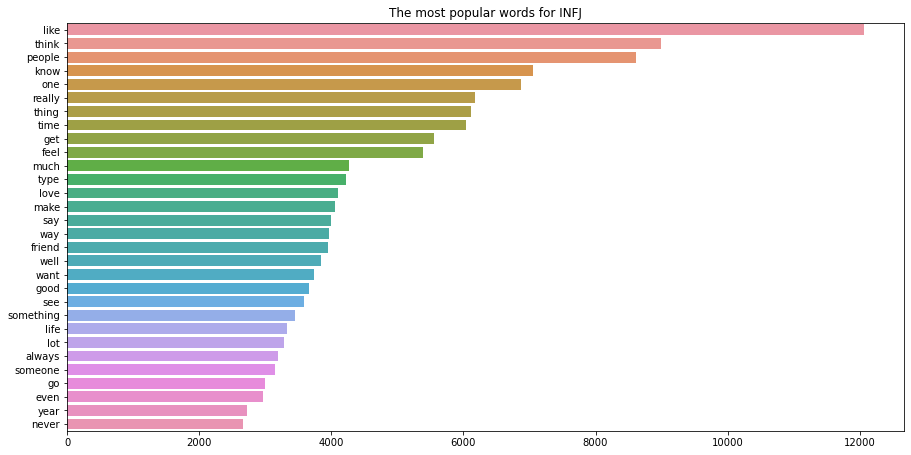

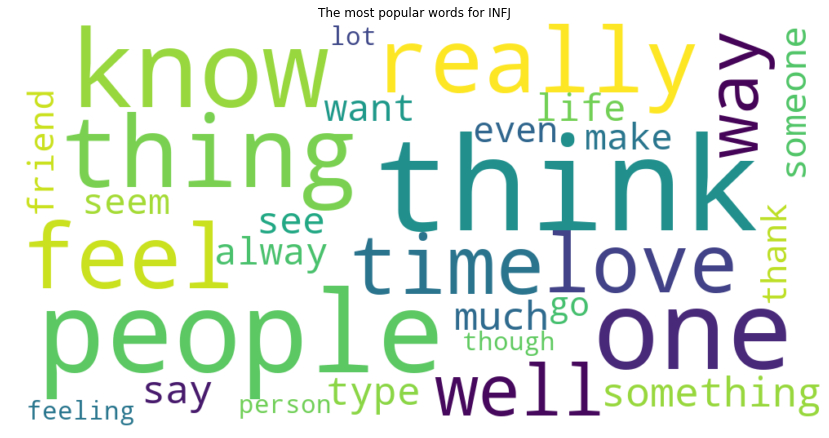

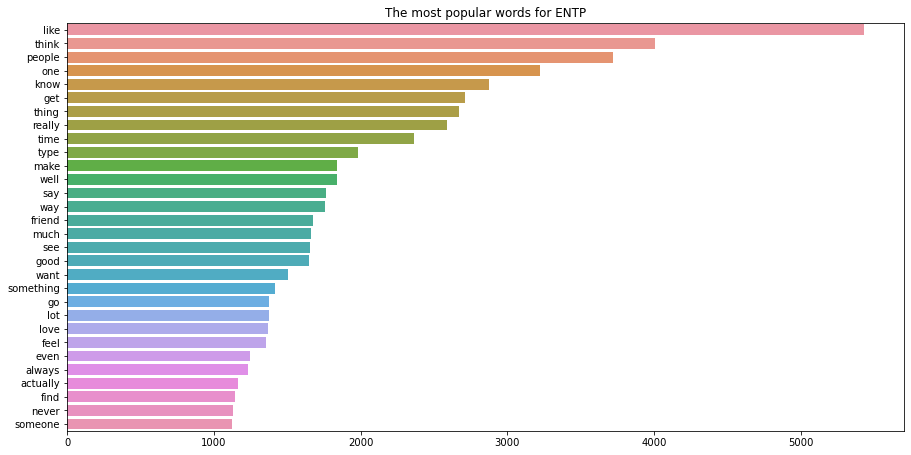

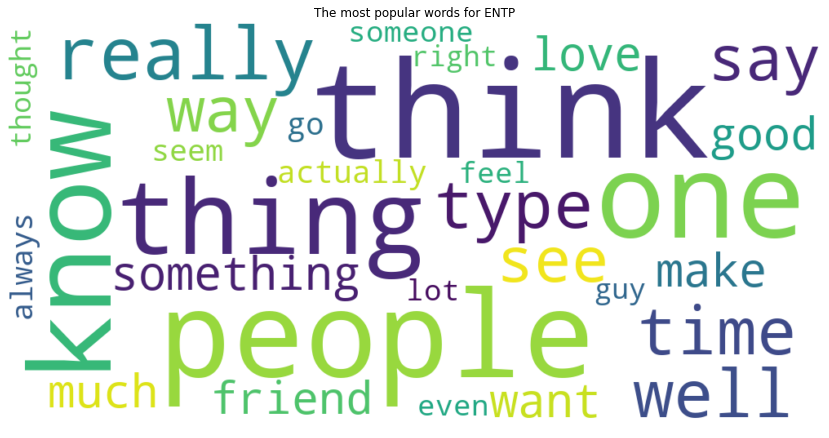

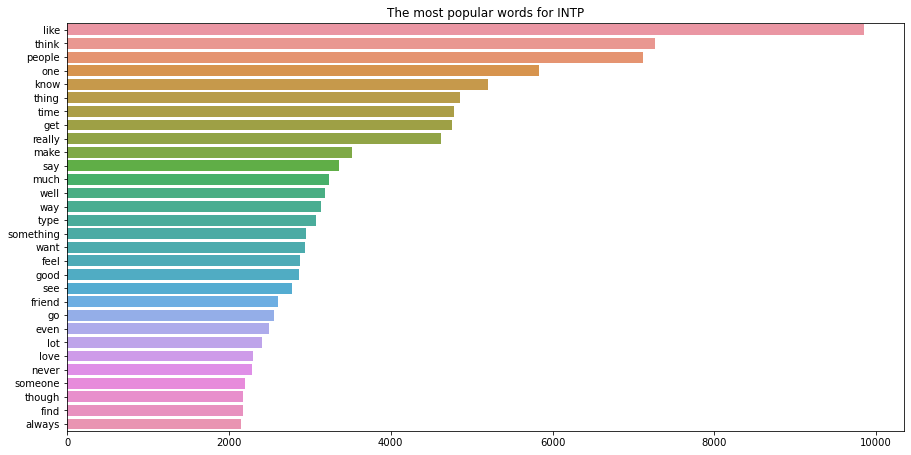

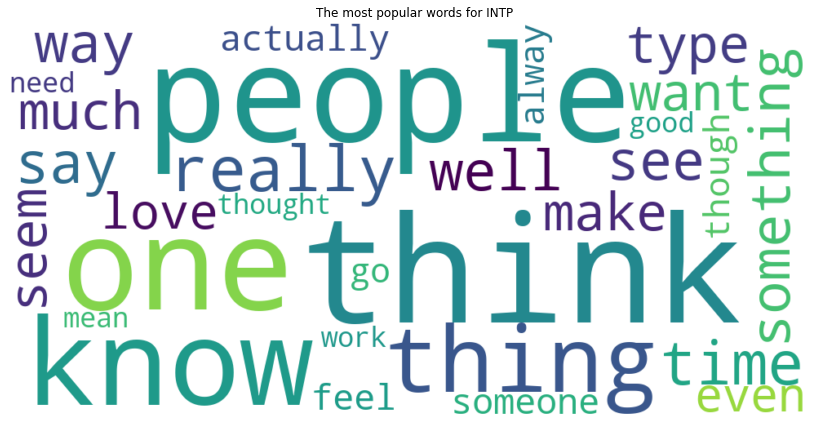

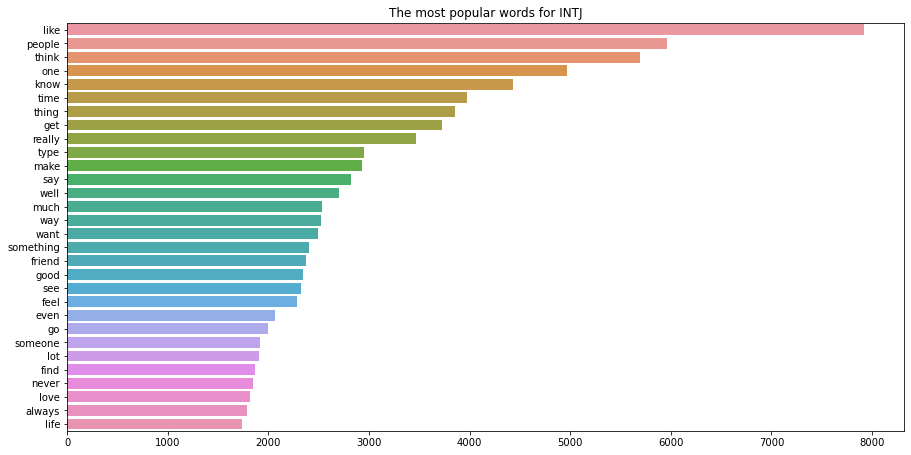

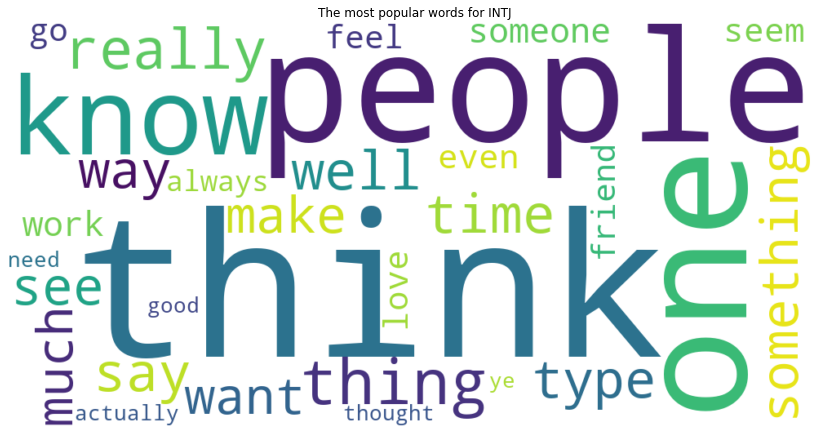

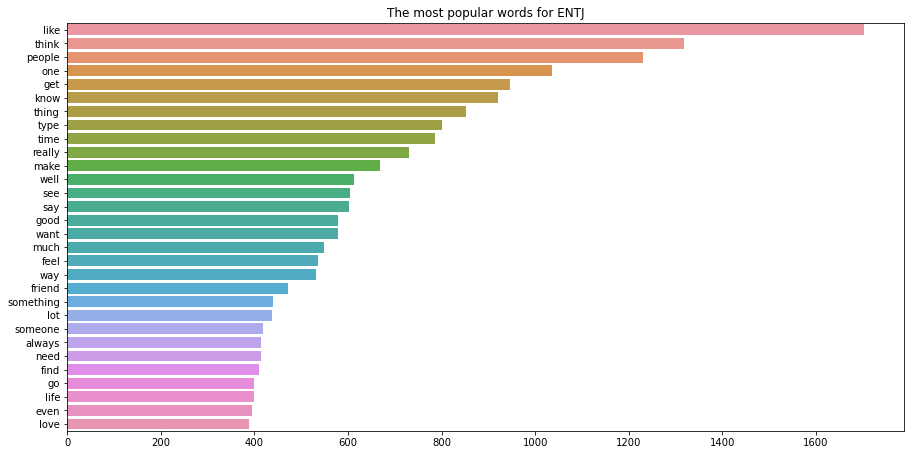

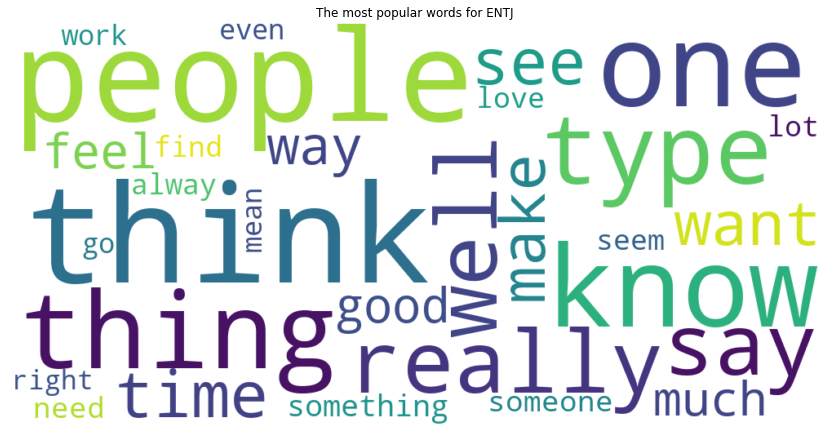

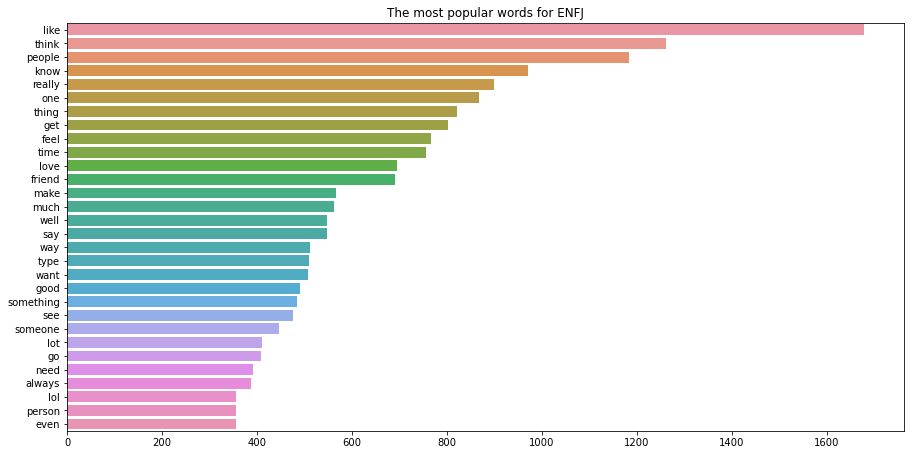

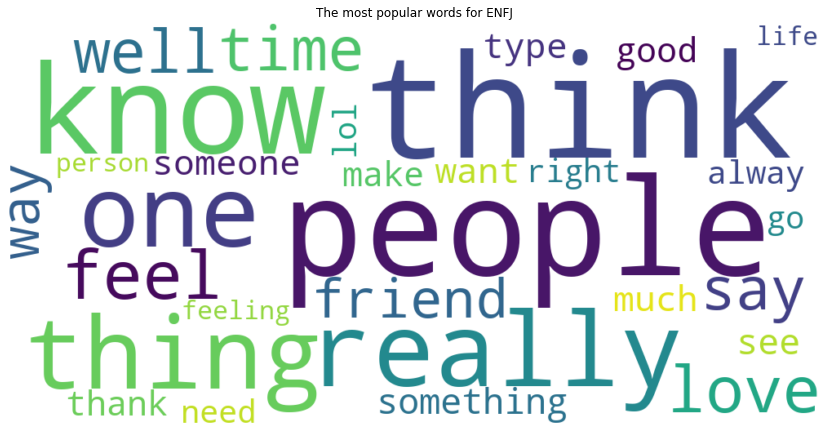

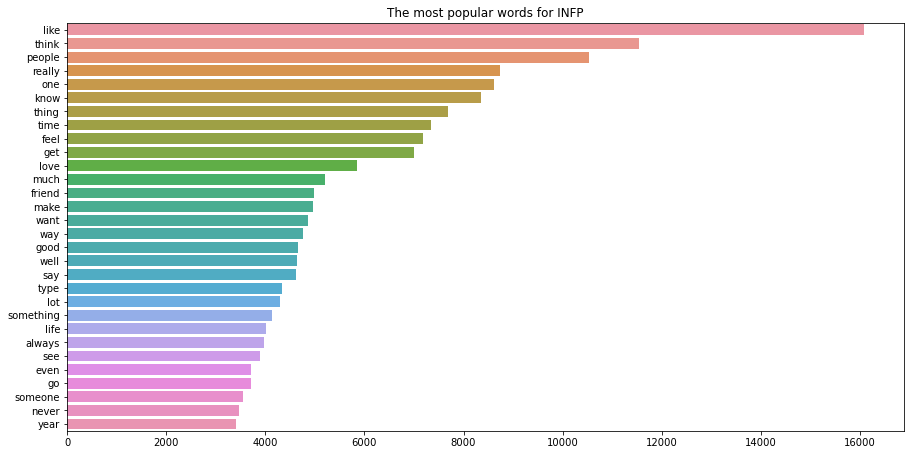

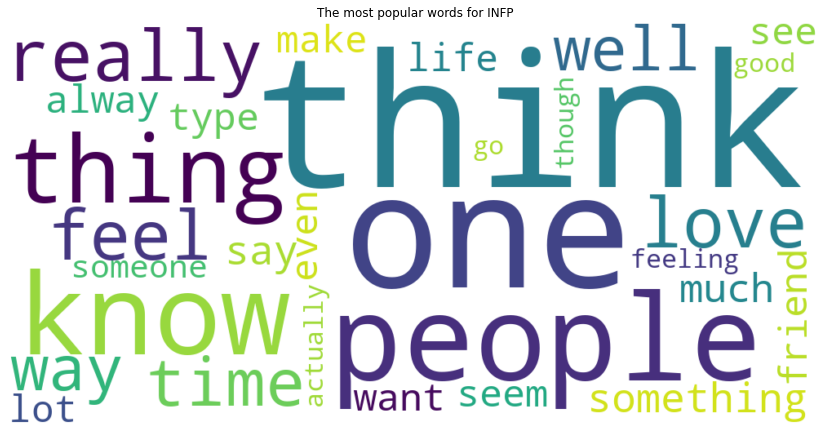

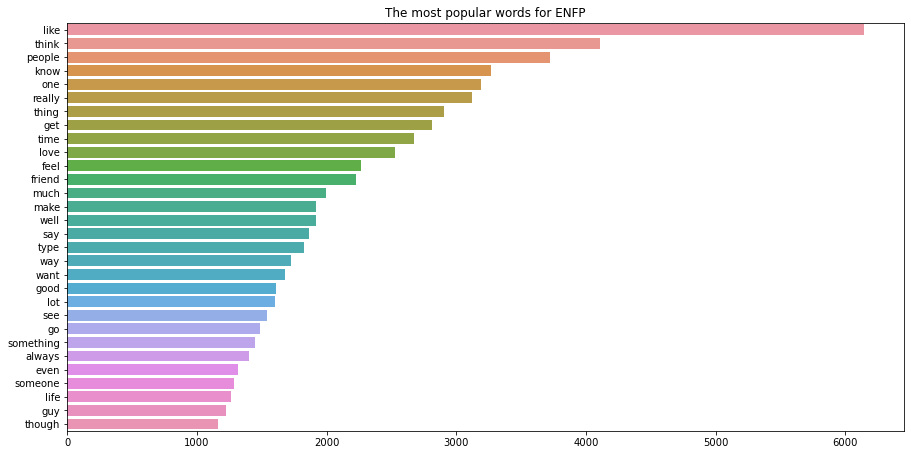

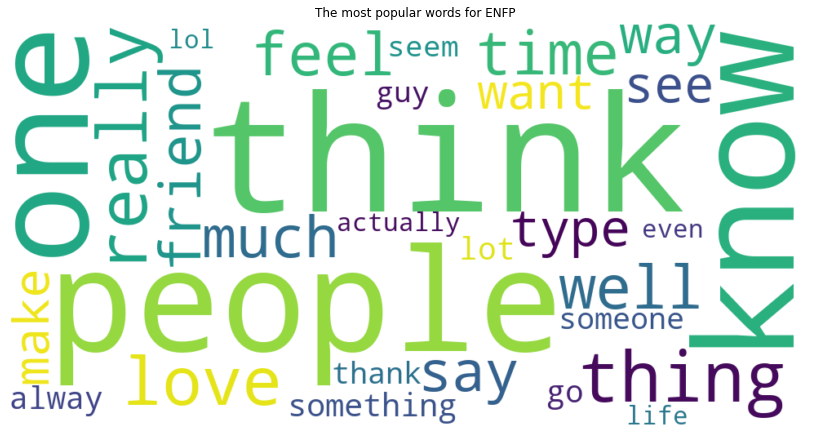

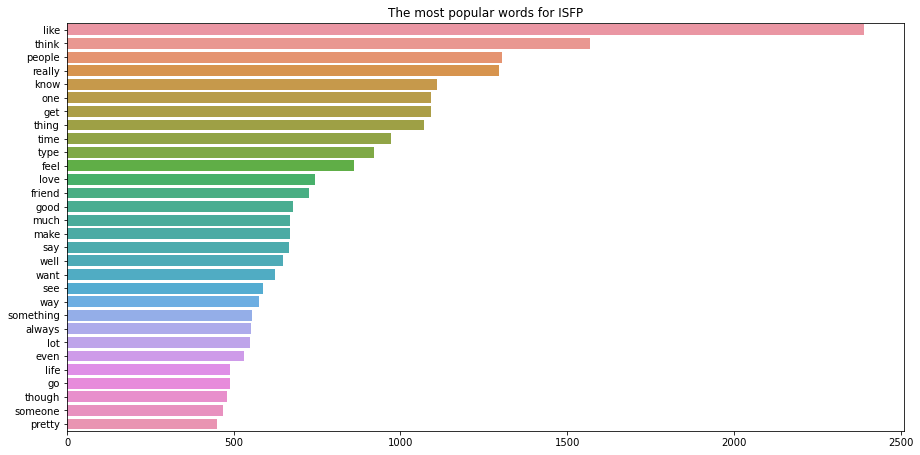

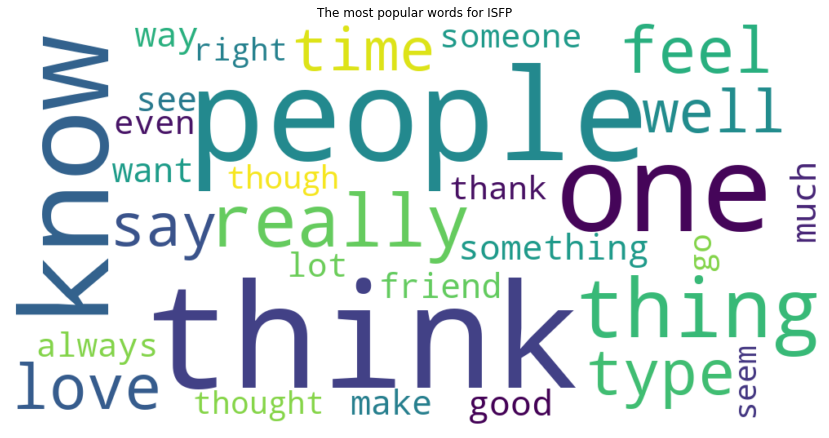

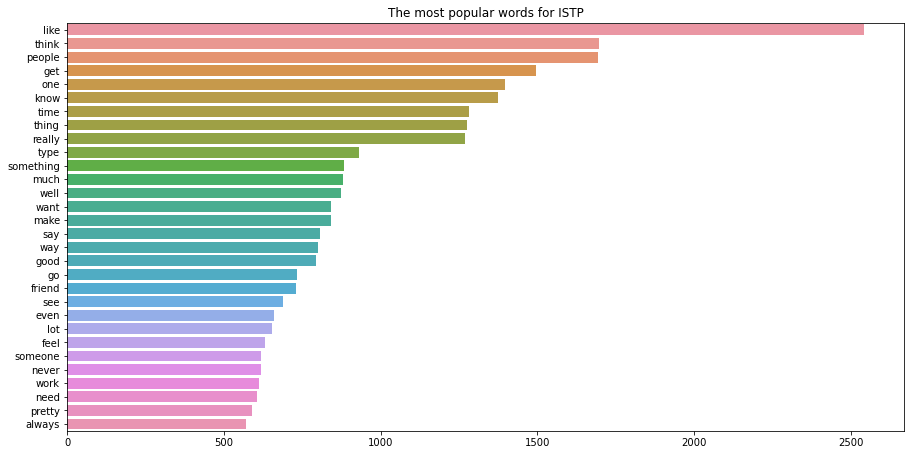

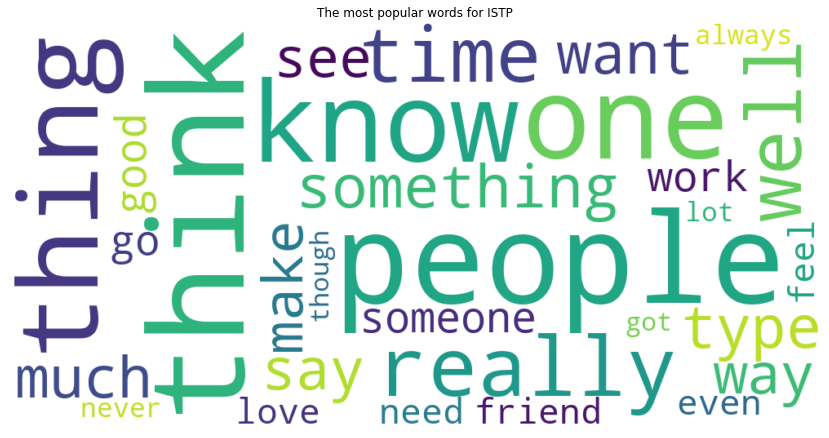

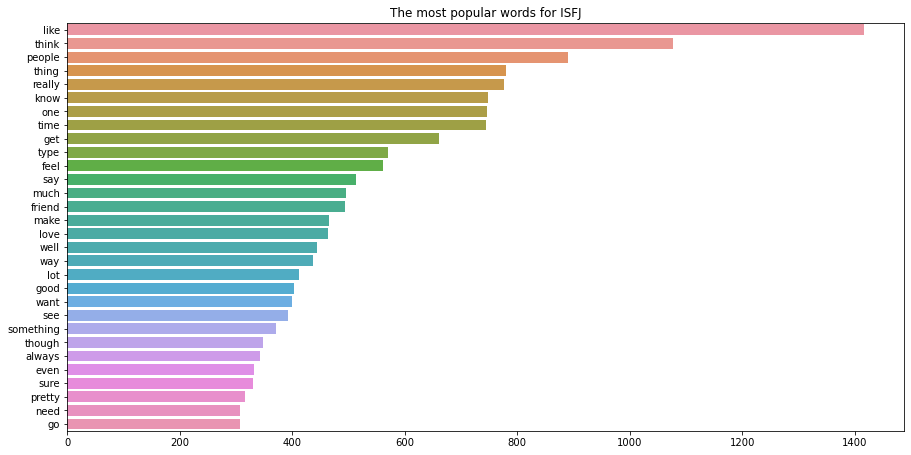

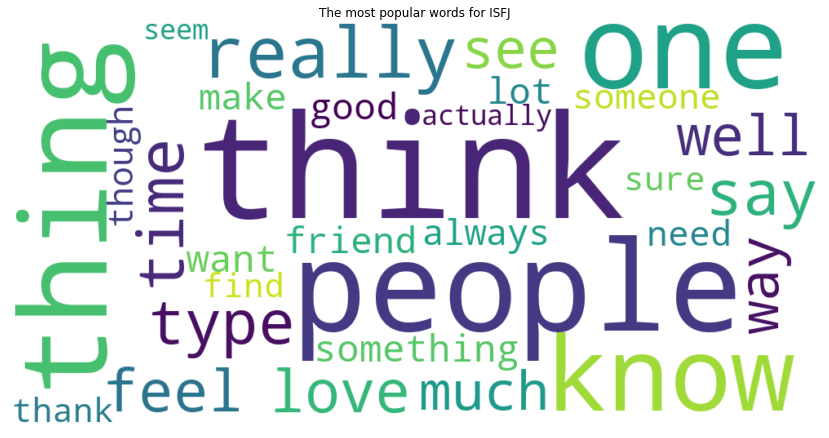

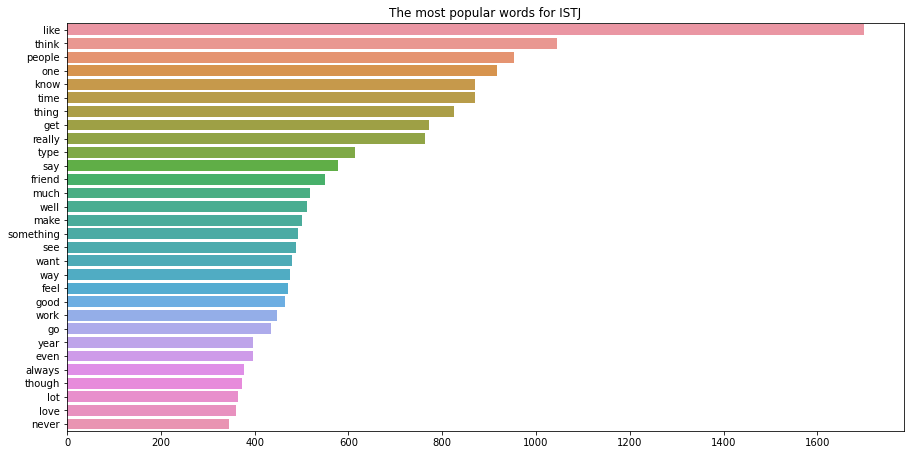

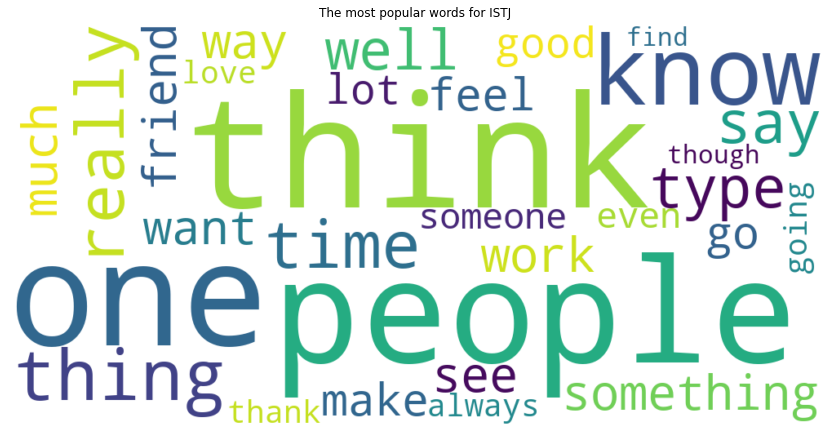

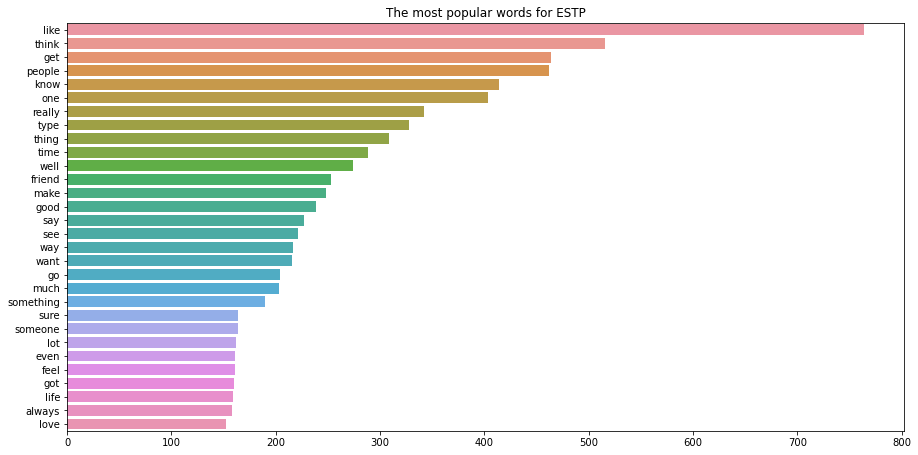

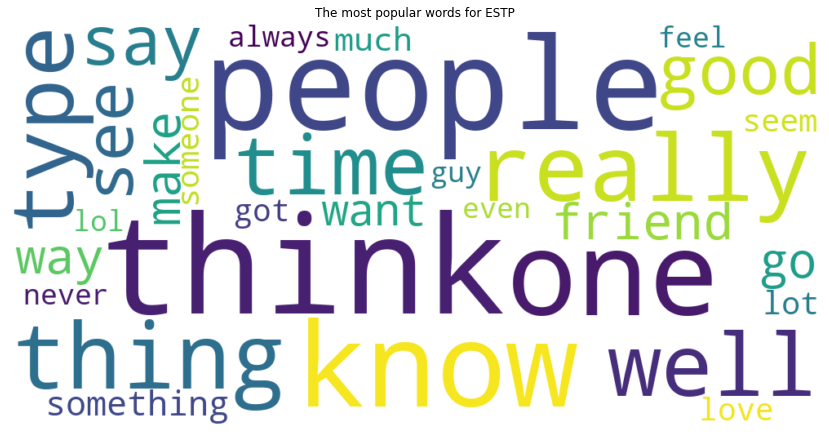

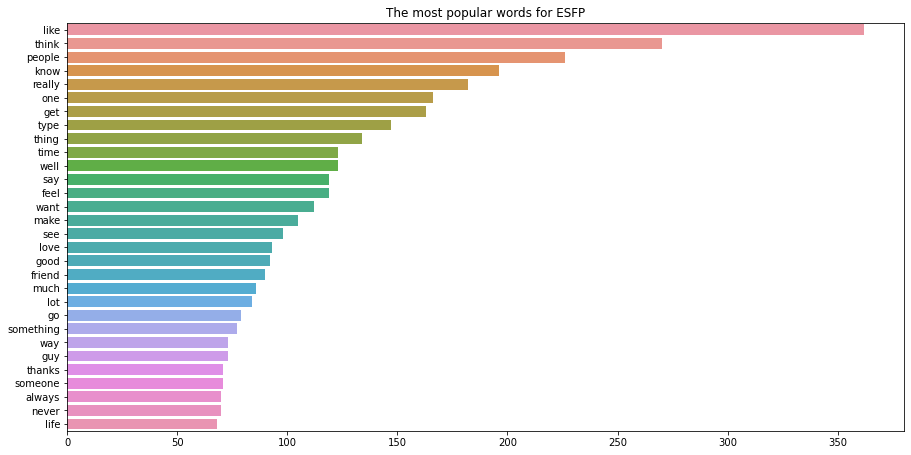

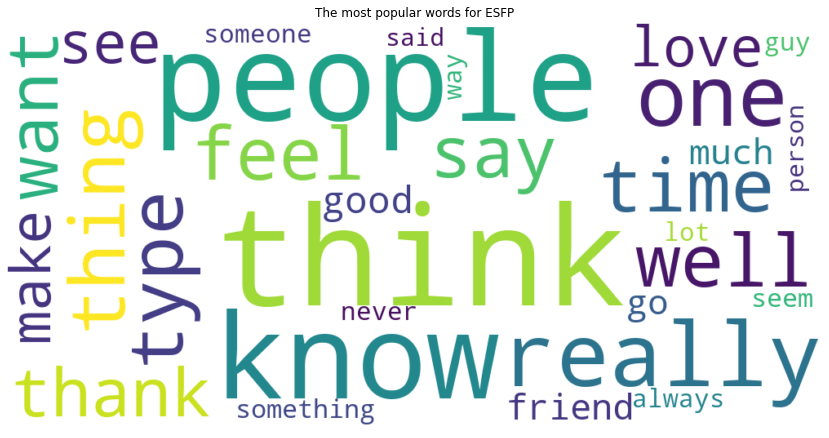

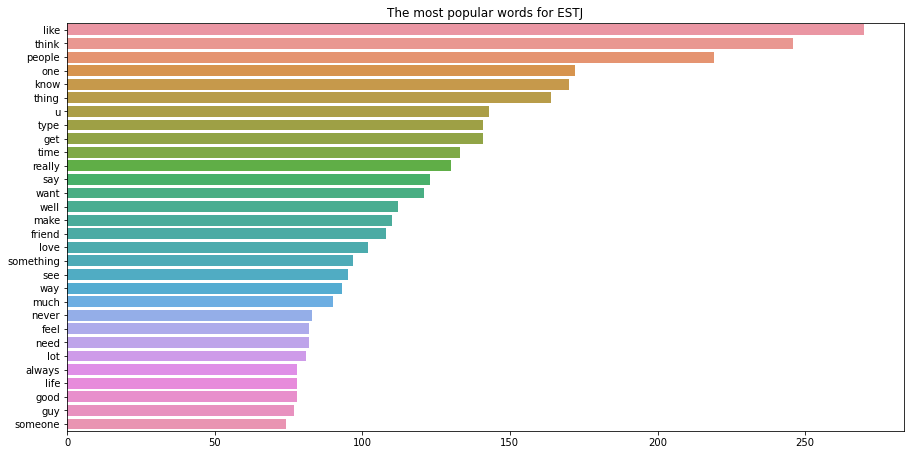

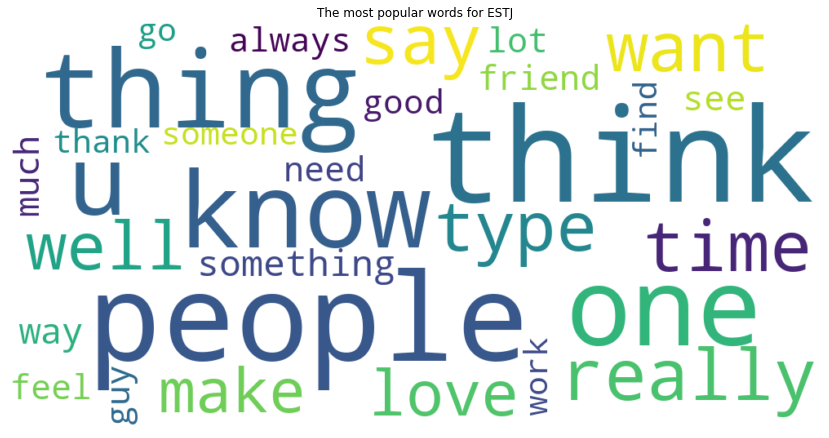

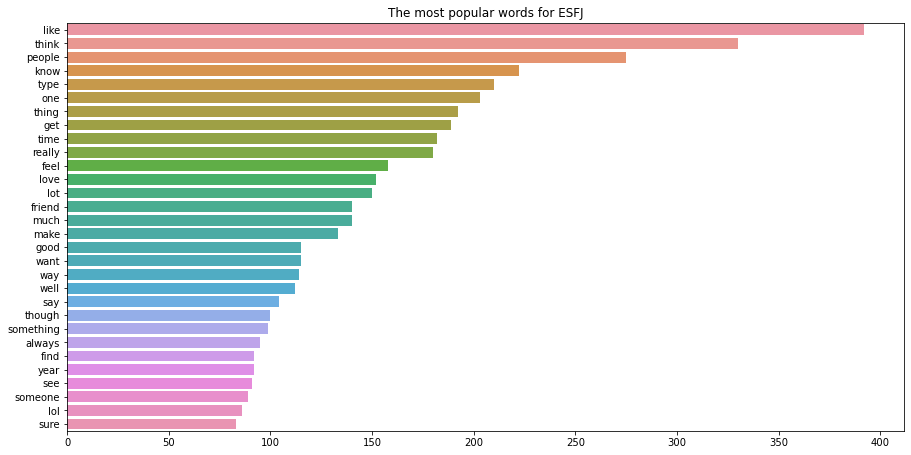

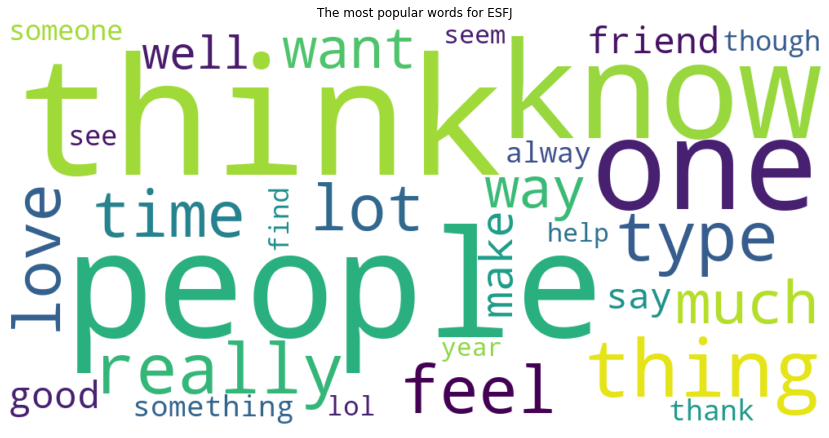

In [196]:
def print_plots():
    for cur_type in MBTI_TYPES:
        plot_wordcloud(df_str, mbti_type=cur_type)

print_plots()

It is really difficult to notice significant difference in popular words for different mbti types. Let's now try to look at `I/E` dichotomy:

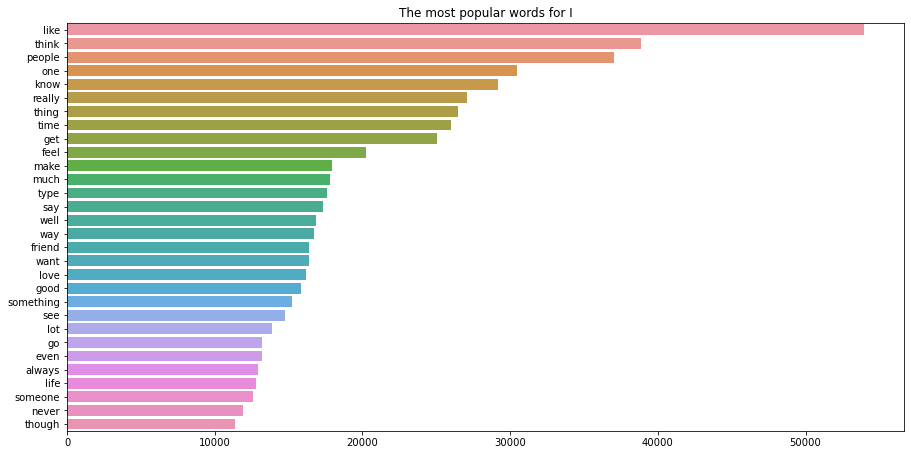

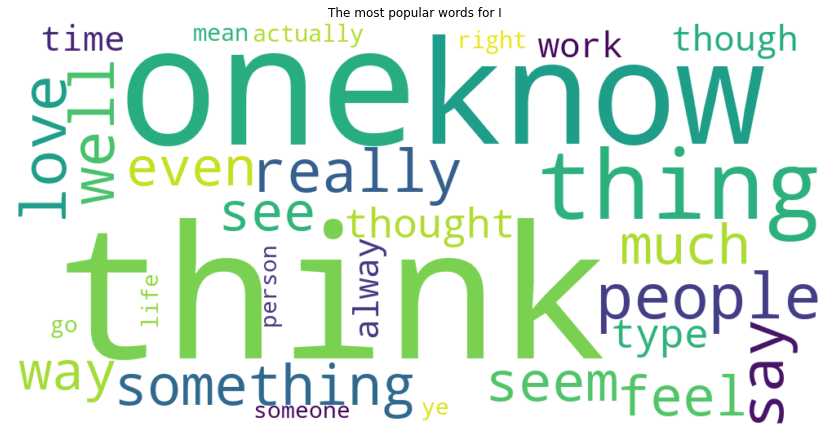

In [121]:
plot_wordcloud(df_str, dichotomy='I/E', dichotomy_type='I')

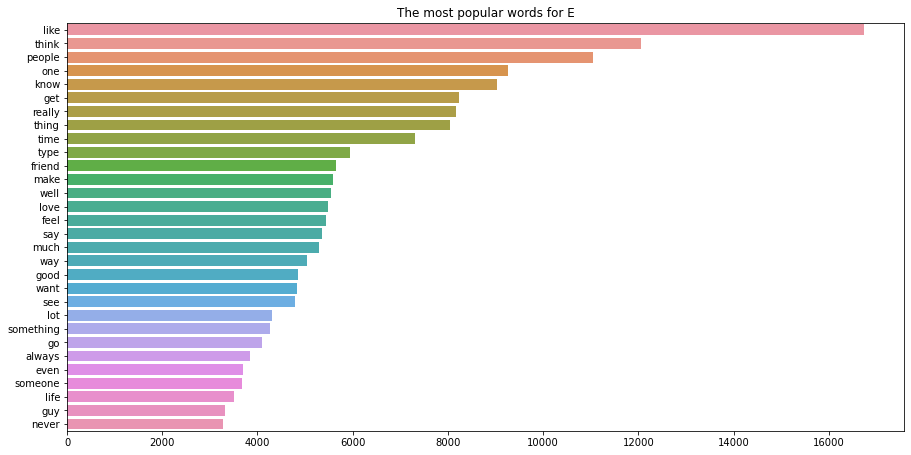

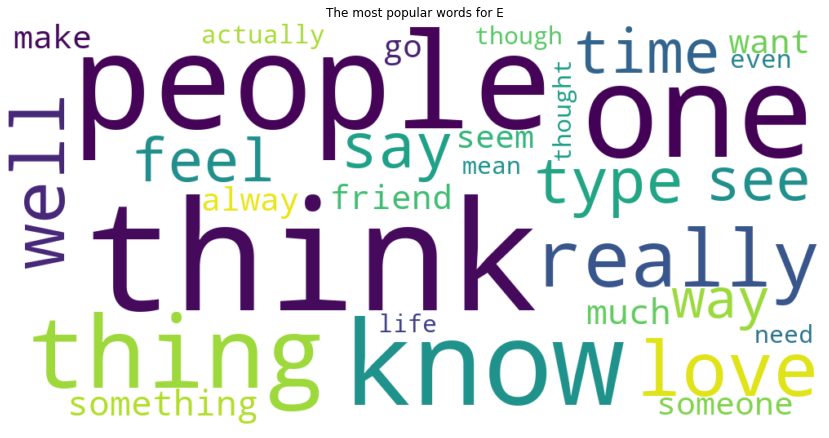

In [122]:
plot_wordcloud(df_str, dichotomy='I/E', dichotomy_type='E')

We see that for introverts and extraverts the most popular words are also similar.

In [126]:
df_features

type     group I/E N/S T/F P/J  avg_length  ratio_capitals  punctuation  \
0     INFJ  diplomat   I   N   F   J   99.562500        0.023096     0.043628   
1     ENTP   analyst   E   N   T   P  138.400000        0.050912     0.046403   
2     INTP   analyst   I   N   T   P  124.282051        0.037456     0.047039   
3     INTJ   analyst   I   N   T   J  124.708333        0.044050     0.049115   
4     ENTJ   analyst   E   N   T   J  123.377778        0.041830     0.041967   
...    ...       ...  ..  ..  ..  ..         ...             ...          ...   
8670  ISFP  explorer   I   S   F   P  105.697674        0.037725     0.036964   
8671  ENFP  diplomat   E   N   F   P  150.540000        0.063309     0.063106   
8672  INTP   analyst   I   N   T   P  118.543478        0.046590     0.047497   
8673  INFP  diplomat   I   N   F   P  185.440000        0.040665     0.047886   
8674  INFP  diplomat   I   N   F   P  148.145833        0.045866     0.043313   

      exclamation_mark    neg    neu    pos     slang  smile  sad  
0             0.000942  0.075  0.788  0.138  0.003546      0    0  
1             0.000000  0.087  0.716  0.197  0.000000      0    0  
2             0.000825  0.079  0.714  0.207  0.001151      0    0  
3             0.000501  0.053  0.812  0.135  0.001810      0    0  
4             0.000180  0.147  0.691  0.161  0.000997      0    0  
...                ...    ...    ...    ...       ...    ...  ...  
8670          0.001320  0.103  0.735  0.162  0.000000      0    0  
8671          0.004384  0.046  0.685  0.269  0.000000      0    0  
8672          0.000183  0.100  0.736  0.165  0.002028      0    0  
8673          0.000324  0.059  0.768  0.173  0.000000      0    0  
8674          0.000703  0.065  0.737  0.198  0.000000      0    0  

[8675 rows x 16 columns]

## Merge with handcrafted features

In [127]:
df_str = pd.merge(df_str, df_features, left_index=True, right_index=True)

In [128]:
df_str.drop(columns=['type_x'], inplace=True)

In [129]:
df_str.rename(columns={'type_y': 'type'}, inplace=True)

In [130]:
df_str.drop(columns=['avg_length_x'], inplace=True)
df_str.rename(columns={'avg_length_y': 'avg_length'}, inplace=True)

In [131]:
df_str.drop(columns=['group_x'], inplace=True)
df_str.rename(columns={'group_y': 'group'}, inplace=True)

In [132]:
df_str.drop(columns=['I/E_x'], inplace=True)
df_str.rename(columns={'I/E_y': 'I/E'}, inplace=True)

In [133]:
df_str.drop(columns=['N/S_x'], inplace=True)
df_str.rename(columns={'N/S_y': 'N/S'}, inplace=True)

In [134]:
df_str.drop(columns=['T/F_x'], inplace=True)
df_str.rename(columns={'T/F_y': 'T/F'}, inplace=True)

In [135]:
df_str.drop(columns=['P/J_x'], inplace=True)
df_str.rename(columns={'P/J_y': 'P/J'}, inplace=True)

In [136]:
df_str

posts  \
0     moment sportscenter top ten play prank lifechanging experience life repeat today may perc experience immerse last thing friend posted facebook committing suicide next day rest peace sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth  welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting de...   
1     finding lack post alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough  giving new meaning game theory hello grin take converse flirting acknowledge presence return word smooth wordplay cheeky grin lack balance hand eye coordination real iq test score internet iq test funny score higher like former response thread mention believe ...   
2     good one course say know blessing curse absolutely positive best friend amazing couple count yes madly love case reconciled feeling  thank link socalled tisi loop stem current topic obsession deadly like stuck thought mind wanders circle feel truly terrible  noticed peculiar vegetation look grass dozen different plant specie imagine hundred year later soil  smith – never one ever often find sp...   
3     dear enjoyed conversation day esoteric gabbing nature universe idea every rule social code arbitrary construct created  dear sub long time see sincerely alpha none type hurt deep existential way want part probably sliding scale depends individual preference like everything humanity draco malfoy say either either though stacking somewhat arbitrary distinction make believe core indicates primary...   
4     fired another silly misconception approaching logically going key unlocking whatever think entitled nobody want approached b  guy  really want go superduperlongass vacation c'm guy bos listen get even approached logically everything never mind go permanent vacation two month crazy idea really best employee may cooking want reliable asset gone long employer  lol like view unsolicited victim som...   
...                                                                                                                                                                                                                                                                                                                                                                                                               ...   
8670  always think cat fi doms reason website become neo nazi perc nerd learning dutch duolingo much fun  duolingo shit oh god love xd right winger lack political consciousness doubt real hope hell nothing like twilight vampire agree likely related confidence level make sense someone aggressive overcompensate sometimes perceived shortcoming nazi germany soviet union extremely nationalist ca think na...   
8671   thread already exists someplace else heck delete one ooops  guess look hard started movie every watch thread  came know  thread pucca go done list film rather one believe  know liked choose feeding joy beating ” buddy wakefield quote pucca;]i've never seen it.:shocked quote neither guess movie marathon movie watch hilarious hahaha used pretend bunch dragon friend whole bunch animal like platy...   
8672  many question thing take purple pill pick winning lottery number whatever want worked brewery couple year know familiar local micros craft mill st name tankhouse favorite anything local going summon great powerful mr cafebot song destruction four horseman ride count day people earth intro nick male basement  thread obviously textbook definition manliness ruffin tuffin going hard mother fking p...   
8673  conflicted right come wanting child honestly maternal instinct whatsoever recently none close friend child  guess closest friend xnfp know correct know know type actually xnfp  said last paragraph  teacher frustrates trend education combine class contain variety type student wo  ca say much trouble comm

# Train/test split

In [137]:
features_names = df_str.loc[:, 'avg_length':].columns.to_list()
features_names.insert(0, 'posts')
features_names

['posts',
 'avg_length',
 'ratio_capitals',
 'punctuation',
 'exclamation_mark',
 'neg',
 'neu',
 'pos',
 'slang',
 'smile',
 'sad']

Train/test split is stratified by mbti type, so there is the same percentage of different types in both train and test dataset.

In [143]:
train_posts_ie, test_posts_ie, train_type_ie, test_type_ie = train_test_split(df_str[features_names], df_str['I/E'], test_size = 0.3, shuffle=True, random_state = 42, stratify=df_str['I/E'])
train_posts_ns, test_posts_ns, train_type_ns, test_type_ns = train_test_split(df_str[features_names], df_str['N/S'], test_size = 0.3, shuffle=True, random_state = 42, stratify=df_str['N/S'])
train_posts_tf, test_posts_tf, train_type_tf, test_type_tf = train_test_split(df_str[features_names], df_str['T/F'], test_size = 0.3, shuffle=True, random_state = 42, stratify=df_str['T/F'])
train_posts_pj, test_posts_pj, train_type_pj, test_type_pj = train_test_split(df_str[features_names], df_str['P/J'], test_size = 0.3, shuffle=True, random_state = 42, stratify=df_str['P/J'])

# Models set up

In [144]:
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer

tf_idf = TfidfVectorizer(max_features=1500)
preprocesser_ie = ColumnTransformer([('vect', tf_idf, 'posts')], 
                                    remainder='passthrough')

train_posts_ie_processed = preprocesser_ie.fit_transform(train_posts_ie)
test_posts_ie_processed = preprocesser_ie.transform(test_posts_ie)

preprocesser_ns = ColumnTransformer([('vect', tf_idf, 'posts')], 
                                    remainder='passthrough')

train_posts_ns_processed = preprocesser_ns.fit_transform(train_posts_ns)
test_posts_ns_processed = preprocesser_ns.transform(test_posts_ns)

preprocesser_tf = ColumnTransformer([('vect', tf_idf, 'posts')], 
                                    remainder='passthrough')

train_posts_tf_processed = preprocesser_ie.fit_transform(train_posts_tf)
test_posts_tf_processed = preprocesser_ie.transform(test_posts_tf)

preprocesser_pj = ColumnTransformer([('vect', tf_idf, 'posts')], 
                                    remainder='passthrough')

train_posts_pj_processed = preprocesser_ie.fit_transform(train_posts_pj)
test_posts_pj_processed = preprocesser_ie.transform(test_posts_pj)

In [145]:
cnb_pipe = Pipeline([('model', ComplementNB())])
rf_pipe = Pipeline([('model', RandomForestClassifier(random_state=42))])
svm_pipe = Pipeline([('model', SVC(random_state=42))])
lr_pipe = Pipeline([('model', LogisticRegression(random_state=42))])
lgb_pipe = Pipeline([('model', LGBMClassifier(random_state=42))])

In [146]:
def get_heatmap(matrix, target_order):
    sns.heatmap(matrix, cmap="Blues", annot=True, 
                xticklabels = target_order,
                yticklabels= target_order, fmt='');

In [155]:
def get_best_params(grid_search, preprocesser, data_x_train, data_y_train,  data_x_test, 
                   data_y_test, model_name, target_order):
  
  # performing grid search
    grid_search.fit(data_x_train, data_y_train)
    print(f"Best parameters for {model_name} are : ", grid_search.best_params_)
    
    print('Confusion matrix for test data')
    
    predicted_results_test = grid_search.predict(data_x_test)
    get_heatmap(confusion_matrix(data_y_test, predicted_results_test), target_order)
    
    print('Metrics for test data')
    print(classification_report(data_y_test, predicted_results_test), target_order)
    
    return grid_search.best_params_, predicted_results_test

In [148]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dichotomy classification

# Introverts/Extraverts

## Complement Naive Bayes

In [156]:
def run_cnb(types_order, preprocesser, X_train, y_train, X_test, y_test):
    alphas = [-10, -5, -1, -0.5, 0.5, 1, 5, 10]
    norm = [False, True]

    dict_cnb = dict(model__alpha = alphas, model__norm = norm)
    
    gs_cnb = GridSearchCV(estimator=cnb_pipe, param_grid=dict_cnb, 
                                 n_jobs=-1, cv=kfold, refit=True, scoring='f1_macro')

    cnb_best_params, preds_cnb = get_best_params(gs_cnb, preprocesser, X_train, y_train, X_test, y_test, 'Complement Naive Bayes', types_order)
    
    return cnb_best_params, preds_cnb


Best parameters for Complement Naive Bayes are :  {'model__alpha': 0.5, 'model__norm': False}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           E       0.37      0.57      0.45       600
           I       0.85      0.71      0.77      2003

    accuracy                           0.68      2603
   macro avg       0.61      0.64      0.61      2603
weighted avg       0.74      0.68      0.70      2603
 ['E', 'I']


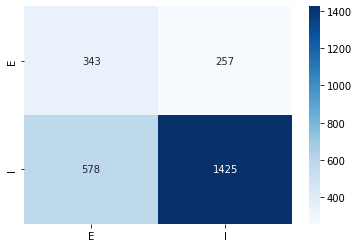

In [145]:
cnb_ie_best_params, preds_cnb_ie = run_cnb(['E', 'I'], preprocesser_ie, train_posts_ie_processed, train_type_ie.copy(deep=True),
                                                     test_posts_ie_processed, test_type_ie.copy(deep=True))

## Random Forest

In [166]:
def run_rf(types_order, preprocesser, X_train, y_train, X_test, y_test):
    n_estimators = [20, 50, 100, 200]
    max_depth = [3, 5, 10, 20]
    max_samples = [0.5, 0.7, 0.9]
    max_features = ['sqrt', 'log2']
    class_weight = ['balanced']

    dict_rf = dict(model__n_estimators = n_estimators, 
                   model__max_depth = max_depth, 
                   model__max_samples = max_samples, 
                   model__max_features = max_features)

    gs_rf = GridSearchCV(estimator=rf_pipe, param_grid=dict_rf, 
                                 n_jobs=-1, cv=kfold, refit=True, scoring='f1_macro')

    rf_best_params, preds_rf = get_best_params(gs_rf, preprocesser, X_train, y_train, X_test, y_test, 'Random Forest', types_order)

    return rf_best_params, preds_rf


Best parameters for Random Forest are :  {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__max_samples': 0.9, 'model__n_estimators': 20}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           E       0.50      0.01      0.02       600
           I       0.77      1.00      0.87      2003

    accuracy                           0.77      2603
   macro avg       0.64      0.50      0.45      2603
weighted avg       0.71      0.77      0.67      2603
 ['E', 'I']


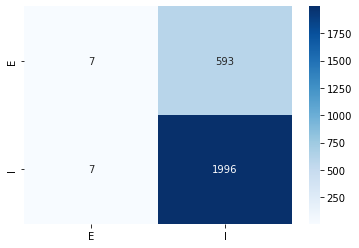

In [189]:
rf_ie_best_params, preds_rf_ie = run_rf(['E', 'I'], preprocesser_ie, train_posts_ie_processed, 
                                               train_type_ie.copy(deep=True), test_posts_ie_processed, test_type_ie.copy(deep=True))


## LightGBM

In [176]:
def run_lgb(types_order, preprocesser, X_train, y_train, X_test, y_test, obj):
    max_depth = [5, 7]
    objective = obj
    class_weight = ['balanced']

    dict_lgb = dict(model__max_depth = max_depth, 
                   model__objective = objective,
                   model__class_weight = class_weight)

    gs_lgb = GridSearchCV(estimator=lgb_pipe, param_grid=dict_lgb, 
                                 n_jobs=-1, cv=kfold, refit=True, scoring='f1_macro')

    lgb_best_params, preds_lgb = get_best_params(gs_lgb, preprocesser, X_train, y_train, X_test, y_test, 'lgb', types_order)
    
    return lgb_best_params, preds_lgb
 

Best parameters for lgb are :  {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__objective': 'binary'}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           E       0.43      0.43      0.43       600
           I       0.83      0.83      0.83      2003

    accuracy                           0.74      2603
   macro avg       0.63      0.63      0.63      2603
weighted avg       0.74      0.74      0.74      2603
 ['E', 'I']


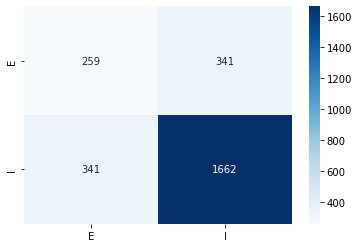

In [182]:
lgb_ie_best_params, preds_lgb_ie = run_lgb(['E', 'I'], preprocesser_ie, train_posts_ie_processed, 
                                               train_type_ie.copy(deep=True), test_posts_ie_processed, test_type_ie.copy(deep=True), ['binary'])  

So, for Introverts/Extraverts dichotomy the best f1 score = 0.63 and it is given by LightGBM classifier with max_depth = 5.

# Intuition/Sensing

## Complement Bayes

Best parameters for Complement Naive Bayes are :  {'model__alpha': 0.5, 'model__norm': False}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           N       0.91      0.75      0.82      2244
           S       0.25      0.54      0.34       359

    accuracy                           0.72      2603
   macro avg       0.58      0.64      0.58      2603
weighted avg       0.82      0.72      0.75      2603
 ['N', 'S']


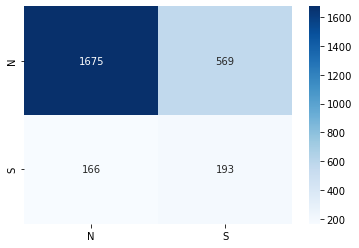

In [190]:
cnb_ns_best_params, preds_cnb_ns = run_cnb(['N', 'S'], preprocesser_ns, train_posts_ns_processed, train_type_ns.copy(deep=True),
                                                     test_posts_ns_processed, test_type_ns.copy(deep=True))

## Random Forest

Best parameters for Random Forest are :  {'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__max_samples': 0.5, 'model__n_estimators': 20}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           N       0.86      1.00      0.93      2244
           S       0.00      0.00      0.00       359

    accuracy                           0.86      2603
   macro avg       0.43      0.50      0.46      2603
weighted avg       0.74      0.86      0.80      2603
 ['N', 'S']


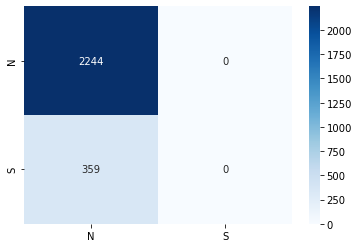

In [191]:
rf_ns_best_params, preds_rf_ns = run_rf(['N', 'S'], preprocesser_ns, train_posts_ns_processed, 
                                               train_type_ns.copy(deep=True), test_posts_ns_processed, test_type_ns.copy(deep=True))


## LightGBM


Best parameters for lgb are :  {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__objective': 'binary'}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           N       0.89      0.89      0.89      2244
           S       0.32      0.31      0.31       359

    accuracy                           0.81      2603
   macro avg       0.60      0.60      0.60      2603
weighted avg       0.81      0.81      0.81      2603
 ['N', 'S']


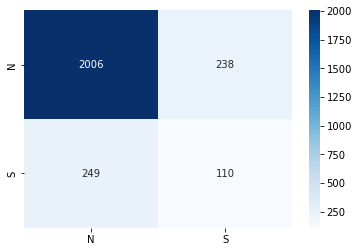

In [184]:
lgb_ns_best_params, preds_lgb_ns = run_lgb(['N', 'S'], preprocesser_ns, train_posts_ns_processed, 
                                               train_type_ns.copy(deep=True), test_posts_ns_processed, test_type_ns.copy(deep=True), ['binary'])  

So, for Intuition/Sensing dichotomy the best f1 score = 0.6 and it is given by LightGBM classifier with max_depth = 5.

# Feeling/Thinking

## Complement Naive Bayes

Best parameters for Complement Naive Bayes are :  {'model__alpha': 1, 'model__norm': False}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           F       0.78      0.79      0.79      1408
           T       0.75      0.74      0.75      1195

    accuracy                           0.77      2603
   macro avg       0.77      0.77      0.77      2603
weighted avg       0.77      0.77      0.77      2603
 ['F', 'T']


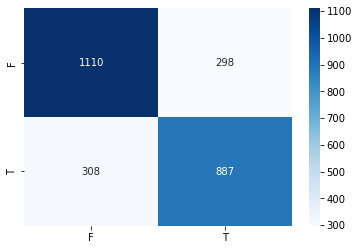

In [192]:
cnb_tf_best_params, preds_cnb_tf = run_cnb(['F', 'T'], preprocesser_tf, train_posts_tf_processed, train_type_tf.copy(deep=True),
                                                     test_posts_tf_processed, test_type_tf.copy(deep=True))

## Random Forest

Best parameters for Random Forest are :  {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__max_samples': 0.7, 'model__n_estimators': 200}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           F       0.74      0.81      0.77      1408
           T       0.75      0.66      0.70      1195

    accuracy                           0.74      2603
   macro avg       0.74      0.74      0.74      2603
weighted avg       0.74      0.74      0.74      2603
 ['F', 'T']


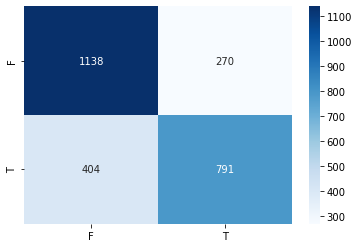

In [194]:
rf_tf_best_params, preds_rf_tf = run_rf(['F', 'T'], preprocesser_tf, train_posts_tf_processed, 
                                               train_type_tf.copy(deep=True), test_posts_tf_processed, test_type_tf.copy(deep=True))

## LightGBM

Best parameters for lgb are :  {'model__class_weight': 'balanced', 'model__max_depth': 7, 'model__objective': 'binary'}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           F       0.79      0.75      0.77      1408
           T       0.72      0.76      0.74      1195

    accuracy                           0.76      2603
   macro avg       0.75      0.76      0.75      2603
weighted avg       0.76      0.76      0.76      2603
 ['F', 'T']


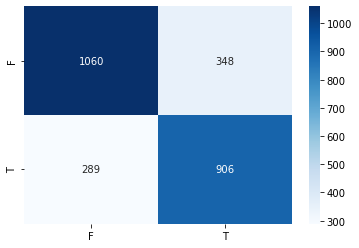

In [186]:
lgb_tf_best_params, preds_lgb_tf = run_lgb(['F', 'T'], preprocesser_tf, train_posts_tf_processed, 
                                               train_type_tf.copy(deep=True), test_posts_tf_processed, test_type_tf.copy(deep=True), ['binary'])  

So, for Feeling/Thinking dichotomy the best f1 score = 0.77 and it is given by Complement Naive Bayes classifier with alpha = 1.

# Judging/Perceiving

## Complement Naive Bayes

Best parameters for Complement Naive Bayes are :  {'model__alpha': 0.5, 'model__norm': False}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           J       0.52      0.61      0.57      1030
           P       0.72      0.63      0.67      1573

    accuracy                           0.63      2603
   macro avg       0.62      0.62      0.62      2603
weighted avg       0.64      0.63      0.63      2603
 ['J', 'P']


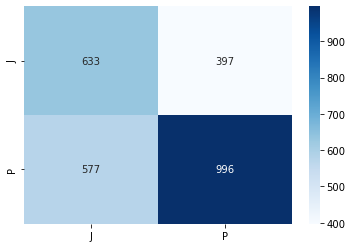

In [193]:
cnb_pj_best_params, preds_cnb_pj = run_cnb(['J', 'P'], preprocesser_pj, train_posts_pj_processed, train_type_pj.copy(deep=True),
                                                     test_posts_pj_processed, test_type_pj.copy(deep=True))

## Random Forest

Best parameters for Random Forest are :  {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__max_samples': 0.9, 'model__n_estimators': 20}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           J       0.51      0.22      0.30      1030
           P       0.63      0.86      0.73      1573

    accuracy                           0.61      2603
   macro avg       0.57      0.54      0.51      2603
weighted avg       0.58      0.61      0.56      2603
 ['J', 'P']


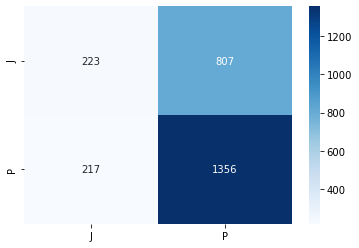

In [195]:
rf_pj_best_params, preds_rf_pj = run_rf(['J', 'P'], preprocesser_pj, train_posts_pj_processed, 
                                               train_type_pj.copy(deep=True), test_posts_pj_processed, test_type_pj.copy(deep=True))

## LightGBM

Best parameters for lgb are :  {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__objective': 'binary'}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

           J       0.54      0.54      0.54      1030
           P       0.70      0.70      0.70      1573

    accuracy                           0.64      2603
   macro avg       0.62      0.62      0.62      2603
weighted avg       0.64      0.64      0.64      2603
 ['J', 'P']


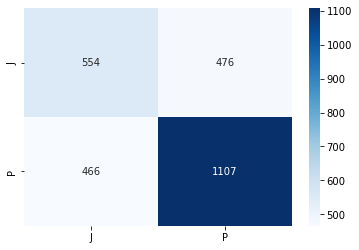

In [188]:
lgb_pj_best_params, preds_lgb_pj = run_lgb(['J', 'P'], preprocesser_pj, train_posts_pj_processed, 
                                               train_type_pj.copy(deep=True), test_posts_pj_processed, test_type_pj.copy(deep=True), ['binary'])  

So, for Judging/Perceiving dichotomy both Complement Naive Bayes and LightGBM give the best f1 score = 0.62.

# Multiclass classification

In [153]:
train_posts_4, test_posts_4, train_type_4, test_type_4 = train_test_split(df_str[features_names], df_str['group'], test_size = 0.3, shuffle=True, random_state = 42, stratify=df_str['group'])

In [154]:
preprocesser_4 = ColumnTransformer([('vect', tf_idf, 'posts')], 
                                    remainder='passthrough')

train_posts_4_processed = preprocesser_4.fit_transform(train_posts_4)
test_posts_4_processed = preprocesser_4.transform(test_posts_4)

## Complement Naive Bayes

Best parameters for Complement Naive Bayes are :  {'model__alpha': 1, 'model__norm': False}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

     analyst       0.62      0.72      0.67       993
    diplomat       0.70      0.75      0.72      1250
    explorer       0.28      0.11      0.16       224
    sentinel       0.33      0.01      0.03       136

    accuracy                           0.65      2603
   macro avg       0.48      0.40      0.39      2603
weighted avg       0.61      0.65      0.62      2603
 ['analyst', 'diplomat', 'explorer', 'sentinel']


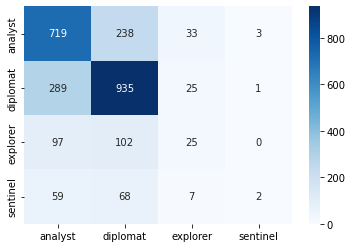

In [163]:
cnb_4_best_params, preds_cnb_4 = run_cnb(['analyst', 'diplomat', 'explorer', 'sentinel'], preprocesser_4, train_posts_4_processed, train_type_4.copy(deep=True),
                                                     test_posts_4_processed, test_type_4.copy(deep=True))

## Random Forest Classifier

Best parameters for Random Forest are :  {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__max_samples': 0.7, 'model__n_estimators': 200}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

     analyst       0.64      0.57      0.60       993
    diplomat       0.62      0.85      0.71      1250
    explorer       0.00      0.00      0.00       224
    sentinel       0.00      0.00      0.00       136

    accuracy                           0.63      2603
   macro avg       0.31      0.36      0.33      2603
weighted avg       0.54      0.63      0.57      2603
 ['analyst', 'diplomat', 'explorer', 'sentinel']


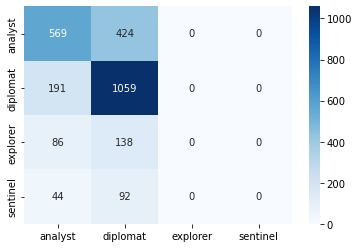

In [168]:
rf_4_best_params, preds_rf_4 = run_rf(['analyst', 'diplomat', 'explorer', 'sentinel'], preprocesser_4, train_posts_4_processed, 
                                               train_type_4.copy(deep=True), test_posts_4_processed, test_type_4.copy(deep=True))

## LightGBM

Best parameters for lgb are :  {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__objective': 'multiclass'}
Confusion matrix for test data
Metrics for test data
              precision    recall  f1-score   support

     analyst       0.64      0.68      0.66       993
    diplomat       0.70      0.74      0.72      1250
    explorer       0.23      0.15      0.18       224
    sentinel       0.17      0.11      0.14       136

    accuracy                           0.63      2603
   macro avg       0.44      0.42      0.42      2603
weighted avg       0.61      0.63      0.62      2603
 ['analyst', 'diplomat', 'explorer', 'sentinel']


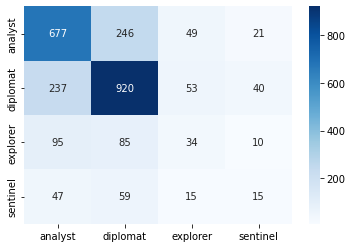

In [177]:
lgb_4_best_params, preds_lgb_4 = run_lgb(['analyst', 'diplomat', 'explorer', 'sentinel'], preprocesser_4, train_posts_4_processed, 
                                               train_type_4.copy(deep=True), test_posts_4_processed, test_type_4.copy(deep=True), ['multiclass'])  

So, the best f1 macro score is 0.42 for LightGBM classifier with parameter max_depth = 5. We can see that for all 3 classifiers f1 score for popular classes (analyst and diplomat) is higher that for less popular explorer and sentinel. Therefore, the imbalancement of the dataset still be a problem even after reducing the number of classes from 16 to 4.